# Transfer Learning with Tensorflow Part 3: Scaling up

We've seen the power of transfer learning featuter extraction and fine-tuning, now its time to scale up to all of the classes in Food101. (101 total classes of food)

Our goal is to beat the original Food101 paper.

Baseline: 50.67%

## Creating helper functions

In previous notebooks we've created series of helper functions but it is difficult to do that every single time so let's download them

In [1]:
def download_helper_functions():
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
#Download the helper function
import os
path = os.getcwd()
if not os.path.exists('/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Transfer Learning/helper_functions.py'):
    download_helper_functions()

--2024-02-21 15:15:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-02-21 15:15:51 (9.73 MB/s) - 'helper_functions.py' saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data

The data we're downlaoding comes from the original Food101 but was preprocessed

In [4]:
if not os.path.exists('/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Transfer Learning/101_food_classes_10_percent.zip'):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data('101_food_classes_10_percent.zip')

In [5]:
TRAIN_DIR = '101_food_classes_10_percent/train/'
TEST_DIR = '101_food_classes_10_percent/test/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'

In [6]:
# How many images classes are there
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

In [7]:
# Setup data inputs
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR, label_mode= LABEL_MODE, image_size= IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, label_mode= LABEL_MODE, image_size= IMG_SIZE, shuffle= False)

Found 7575 files belonging to 101 classes.


2024-02-21 15:15:54.071604: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-21 15:15:54.071635: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-21 15:15:54.071650: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-21 15:15:54.071684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-21 15:15:54.071701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Steps we're going to take:
* Create a ModelCcheckpoint callback
* Create a data augmnetation layer to build data augmentation right into the model
* Build a headless Functional EfficientNetB0 backbone-model
* Comple our model
* Feature extract for 5 full passes (15% of test dataset which will be the validation dataset   )

In [8]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only= True, monitor= "val_accuracy", save_best_only= True)

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # preprocessing.Rescalinig(1/255.) required onlu if the data scaling is not present in the model
], name= 'data_augmentation_layer')

In [15]:
# Setup the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False)
base_model.trainable = False

# Setup model archtecture with trainable top layers
inputs = layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training= False) # put the base model n inference mode so the weights which need to stay frozen stay as it is
x = layers.GlobalAveragePooling2D(name= "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation= "softmax", name= "output_layer")(x)

model = tf.keras.Model(inputs, outputs)


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [20]:
# Compiilng the model
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.legacy.Adam(),
              metrics= ['accuracy'])

In [25]:
with tf.device('/device:GPU:0'):
    history_10_percent = model.fit(train_data,
                                epochs= 5,
                                steps_per_epoch= len(train_data),
                                validation_data= test_data,
                                validation_steps= int(0.15 * len(test_data)))

Epoch 1/5


2024-02-21 15:27:15.117715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-21 15:27:15.480373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/237 [..............................] - ETA: 11:24 - loss: 4.7208 - accuracy: 0.0000e+00

2024-02-21 15:27:16.538627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/237 [..............................] - ETA: 2:21 - loss: 4.7748 - accuracy: 0.0000e+00 

2024-02-21 15:27:17.142244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/237 [..............................] - ETA: 2:37 - loss: 4.7555 - accuracy: 0.0000e+00

2024-02-21 15:27:17.880871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/237 [..............................] - ETA: 2:33 - loss: 4.6892 - accuracy: 0.0000e+00

2024-02-21 15:27:18.516066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/237 [..............................] - ETA: 2:37 - loss: 4.6951 - accuracy: 0.0000e+00

2024-02-21 15:27:19.254605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/237 [..............................] - ETA: 2:38 - loss: 4.7058 - accuracy: 0.0000e+00

2024-02-21 15:27:19.964923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/237 [..............................] - ETA: 2:37 - loss: 4.7227 - accuracy: 0.0000e+00

2024-02-21 15:27:20.646221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/237 [>.............................] - ETA: 2:45 - loss: 4.6909 - accuracy: 0.0000e+00

2024-02-21 15:27:21.599963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/237 [>.............................] - ETA: 2:42 - loss: 4.6857 - accuracy: 0.0000e+00

2024-02-21 15:27:22.227607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/237 [>.............................] - ETA: 2:39 - loss: 4.6785 - accuracy: 0.0000e+00

2024-02-21 15:27:22.862136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/237 [>.............................] - ETA: 2:42 - loss: 4.6791 - accuracy: 0.0028    

2024-02-21 15:27:23.737971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/237 [>.............................] - ETA: 2:48 - loss: 4.6855 - accuracy: 0.0052

2024-02-21 15:27:24.774868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/237 [>.............................] - ETA: 2:46 - loss: 4.6697 - accuracy: 0.0072

2024-02-21 15:27:25.440416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/237 [>.............................] - ETA: 2:40 - loss: 4.6840 - accuracy: 0.0089

2024-02-21 15:27:25.890705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/237 [>.............................] - ETA: 2:35 - loss: 4.6875 - accuracy: 0.0104

2024-02-21 15:27:26.359567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/237 [=>............................] - ETA: 2:28 - loss: 4.6828 - accuracy: 0.0117

2024-02-21 15:27:26.608507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/237 [=>............................] - ETA: 2:25 - loss: 4.6673 - accuracy: 0.0129

2024-02-21 15:27:27.103835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/237 [=>............................] - ETA: 2:23 - loss: 4.6636 - accuracy: 0.0156

2024-02-21 15:27:27.706421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/237 [=>............................] - ETA: 2:24 - loss: 4.6639 - accuracy: 0.0148

2024-02-21 15:27:28.454924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/237 [=>............................] - ETA: 2:22 - loss: 4.6629 - accuracy: 0.0172

2024-02-21 15:27:29.000516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/237 [=>............................] - ETA: 2:18 - loss: 4.6512 - accuracy: 0.0179

2024-02-21 15:27:29.404547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/237 [=>............................] - ETA: 2:19 - loss: 4.6429 - accuracy: 0.0185

2024-02-21 15:27:30.124185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/237 [=>............................] - ETA: 2:15 - loss: 4.6377 - accuracy: 0.0217

2024-02-21 15:27:30.450603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/237 [==>...........................] - ETA: 2:12 - loss: 4.6335 - accuracy: 0.0234

2024-02-21 15:27:30.826330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/237 [==>...........................] - ETA: 2:11 - loss: 4.6142 - accuracy: 0.0275

2024-02-21 15:27:31.452761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/237 [==>...........................] - ETA: 2:10 - loss: 4.6042 - accuracy: 0.0300

2024-02-21 15:27:32.045548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/237 [==>...........................] - ETA: 2:09 - loss: 4.5991 - accuracy: 0.0312

2024-02-21 15:27:32.621262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/237 [==>...........................] - ETA: 2:10 - loss: 4.5900 - accuracy: 0.0301

2024-02-21 15:27:33.381350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/237 [==>...........................] - ETA: 2:08 - loss: 4.5804 - accuracy: 0.0323

2024-02-21 15:27:33.939071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/237 [==>...........................] - ETA: 2:09 - loss: 4.5693 - accuracy: 0.0344

2024-02-21 15:27:34.688981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/237 [==>...........................] - ETA: 2:07 - loss: 4.5591 - accuracy: 0.0363

2024-02-21 15:27:35.107352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/237 [===>..........................] - ETA: 2:08 - loss: 4.5435 - accuracy: 0.0381

2024-02-21 15:27:36.005359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/237 [===>..........................] - ETA: 2:07 - loss: 4.5320 - accuracy: 0.0398

2024-02-21 15:27:36.489506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/237 [===>..........................] - ETA: 2:06 - loss: 4.5199 - accuracy: 0.0423

2024-02-21 15:27:37.154211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/237 [===>..........................] - ETA: 2:06 - loss: 4.5039 - accuracy: 0.0464

2024-02-21 15:27:37.810514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/237 [===>..........................] - ETA: 2:05 - loss: 4.4950 - accuracy: 0.0495

2024-02-21 15:27:38.394691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/237 [===>..........................] - ETA: 2:03 - loss: 4.4822 - accuracy: 0.0549

2024-02-21 15:27:38.743703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/237 [===>..........................] - ETA: 2:02 - loss: 4.4695 - accuracy: 0.0576

2024-02-21 15:27:39.316443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/237 [===>..........................] - ETA: 2:01 - loss: 4.4537 - accuracy: 0.0601

2024-02-21 15:27:39.924086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/237 [====>.........................] - ETA: 2:03 - loss: 4.4469 - accuracy: 0.0602

2024-02-21 15:27:41.041335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/237 [====>.........................] - ETA: 2:04 - loss: 4.4389 - accuracy: 0.0617

2024-02-21 15:27:41.952125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/237 [====>.........................] - ETA: 2:02 - loss: 4.4228 - accuracy: 0.0647

2024-02-21 15:27:42.362993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/237 [====>.........................] - ETA: 2:01 - loss: 4.4104 - accuracy: 0.0661

2024-02-21 15:27:42.849890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/237 [====>.........................] - ETA: 2:00 - loss: 4.4000 - accuracy: 0.0689

2024-02-21 15:27:43.421330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/237 [====>.........................] - ETA: 1:59 - loss: 4.3919 - accuracy: 0.0708

2024-02-21 15:27:43.899966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/237 [====>.........................] - ETA: 1:57 - loss: 4.3827 - accuracy: 0.0713

2024-02-21 15:27:44.293267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/237 [====>.........................] - ETA: 1:56 - loss: 4.3736 - accuracy: 0.0711

2024-02-21 15:27:44.651930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/237 [=====>........................] - ETA: 1:55 - loss: 4.3673 - accuracy: 0.0716

2024-02-21 15:27:45.319891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/237 [=====>........................] - ETA: 1:53 - loss: 4.3559 - accuracy: 0.0753

2024-02-21 15:27:45.572937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/237 [=====>........................] - ETA: 1:53 - loss: 4.3488 - accuracy: 0.0769

2024-02-21 15:27:46.176530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/237 [=====>........................] - ETA: 1:53 - loss: 4.3384 - accuracy: 0.0797

2024-02-21 15:27:47.157106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/237 [=====>........................] - ETA: 1:53 - loss: 4.3324 - accuracy: 0.0811

2024-02-21 15:27:47.825434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/237 [=====>........................] - ETA: 1:53 - loss: 4.3276 - accuracy: 0.0831

2024-02-21 15:27:48.662007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/237 [=====>........................] - ETA: 1:53 - loss: 4.3134 - accuracy: 0.0885

2024-02-21 15:27:49.306446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/237 [=====>........................] - ETA: 1:52 - loss: 4.3034 - accuracy: 0.0909

2024-02-21 15:27:50.028993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/237 [======>.......................] - ETA: 1:51 - loss: 4.2957 - accuracy: 0.0926

2024-02-21 15:27:50.564819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/237 [======>.......................] - ETA: 1:51 - loss: 4.2871 - accuracy: 0.0938

2024-02-21 15:27:51.238542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/237 [======>.......................] - ETA: 1:51 - loss: 4.2804 - accuracy: 0.0943

2024-02-21 15:27:52.060061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/237 [======>.......................] - ETA: 1:50 - loss: 4.2756 - accuracy: 0.0948

2024-02-21 15:27:52.621210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/237 [======>.......................] - ETA: 1:49 - loss: 4.2671 - accuracy: 0.0958

2024-02-21 15:27:53.050369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/237 [======>.......................] - ETA: 1:50 - loss: 4.2590 - accuracy: 0.0978

2024-02-21 15:27:54.176161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/237 [======>.......................] - ETA: 1:49 - loss: 4.2536 - accuracy: 0.0988

2024-02-21 15:27:54.708209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/237 [======>.......................] - ETA: 1:49 - loss: 4.2486 - accuracy: 0.1007

2024-02-21 15:27:55.414267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/237 [=======>......................] - ETA: 1:48 - loss: 4.2411 - accuracy: 0.1016

2024-02-21 15:27:56.135311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/237 [=======>......................] - ETA: 1:48 - loss: 4.2325 - accuracy: 0.1029

2024-02-21 15:27:56.963721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/237 [=======>......................] - ETA: 1:48 - loss: 4.2221 - accuracy: 0.1051

2024-02-21 15:27:57.809345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/237 [=======>......................] - ETA: 1:48 - loss: 4.2168 - accuracy: 0.1063

2024-02-21 15:27:58.559747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/237 [=======>......................] - ETA: 1:46 - loss: 4.2063 - accuracy: 0.1089

2024-02-21 15:27:58.923455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/237 [=======>......................] - ETA: 1:46 - loss: 4.1971 - accuracy: 0.1105

2024-02-21 15:27:59.479877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/237 [=======>......................] - ETA: 1:45 - loss: 4.1922 - accuracy: 0.1098

2024-02-21 15:28:00.145358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/237 [=======>......................] - ETA: 1:44 - loss: 4.1832 - accuracy: 0.1122

2024-02-21 15:28:00.731824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/237 [========>.....................] - ETA: 1:44 - loss: 4.1748 - accuracy: 0.1141

2024-02-21 15:28:01.298787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/237 [========>.....................] - ETA: 1:44 - loss: 4.1676 - accuracy: 0.1156

2024-02-21 15:28:02.242707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/237 [========>.....................] - ETA: 1:43 - loss: 4.1602 - accuracy: 0.1178

2024-02-21 15:28:02.687627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/237 [========>.....................] - ETA: 1:42 - loss: 4.1494 - accuracy: 0.1208

2024-02-21 15:28:03.173325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/237 [========>.....................] - ETA: 1:41 - loss: 4.1404 - accuracy: 0.1242

2024-02-21 15:28:03.805802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/237 [========>.....................] - ETA: 1:40 - loss: 4.1330 - accuracy: 0.1258

2024-02-21 15:28:04.479454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/237 [========>.....................] - ETA: 1:40 - loss: 4.1257 - accuracy: 0.1270

2024-02-21 15:28:04.990362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/237 [=========>....................] - ETA: 1:39 - loss: 4.1154 - accuracy: 0.1286

2024-02-21 15:28:05.508855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/237 [=========>....................] - ETA: 1:38 - loss: 4.1066 - accuracy: 0.1301

2024-02-21 15:28:06.151818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/237 [=========>....................] - ETA: 1:38 - loss: 4.0998 - accuracy: 0.1316

2024-02-21 15:28:06.868485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/237 [=========>....................] - ETA: 1:38 - loss: 4.0938 - accuracy: 0.1319

2024-02-21 15:28:07.977069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/237 [=========>....................] - ETA: 1:38 - loss: 4.0861 - accuracy: 0.1325

2024-02-21 15:28:08.760426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/237 [=========>....................] - ETA: 1:37 - loss: 4.0779 - accuracy: 0.1339

2024-02-21 15:28:09.248517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/237 [=========>....................] - ETA: 1:36 - loss: 4.0714 - accuracy: 0.1353

2024-02-21 15:28:09.894450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/237 [=========>....................] - ETA: 1:36 - loss: 4.0671 - accuracy: 0.1359

2024-02-21 15:28:10.940578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/237 [==========>...................] - ETA: 1:35 - loss: 4.0603 - accuracy: 0.1361

2024-02-21 15:28:11.446928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/237 [==========>...................] - ETA: 1:34 - loss: 4.0537 - accuracy: 0.1385

2024-02-21 15:28:11.977177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/237 [==========>...................] - ETA: 1:34 - loss: 4.0488 - accuracy: 0.1390

2024-02-21 15:28:12.462408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/237 [==========>...................] - ETA: 1:33 - loss: 4.0421 - accuracy: 0.1399

2024-02-21 15:28:12.964091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/237 [==========>...................] - ETA: 1:32 - loss: 4.0372 - accuracy: 0.1405

2024-02-21 15:28:13.623834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/237 [==========>...................] - ETA: 1:31 - loss: 4.0330 - accuracy: 0.1410

2024-02-21 15:28:14.264421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/237 [==========>...................] - ETA: 1:31 - loss: 4.0297 - accuracy: 0.1408

2024-02-21 15:28:14.847251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/237 [==========>...................] - ETA: 1:30 - loss: 4.0228 - accuracy: 0.1420

2024-02-21 15:28:15.344551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/237 [===========>..................] - ETA: 1:29 - loss: 4.0169 - accuracy: 0.1431

2024-02-21 15:28:16.017893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/237 [===========>..................] - ETA: 1:29 - loss: 4.0129 - accuracy: 0.1445

2024-02-21 15:28:16.704582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/237 [===========>..................] - ETA: 1:29 - loss: 4.0086 - accuracy: 0.1459

2024-02-21 15:28:17.791561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/237 [===========>..................] - ETA: 1:29 - loss: 4.0024 - accuracy: 0.1464

2024-02-21 15:28:18.695918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/237 [===========>..................] - ETA: 1:28 - loss: 3.9955 - accuracy: 0.1474

2024-02-21 15:28:19.476627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/237 [===========>..................] - ETA: 1:28 - loss: 3.9870 - accuracy: 0.1497

2024-02-21 15:28:20.159060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/237 [===========>..................] - ETA: 1:27 - loss: 3.9809 - accuracy: 0.1504

2024-02-21 15:28:20.752807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/237 [===========>..................] - ETA: 1:27 - loss: 3.9780 - accuracy: 0.1501

2024-02-21 15:28:21.755716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/237 [============>.................] - ETA: 1:26 - loss: 3.9721 - accuracy: 0.1511

2024-02-21 15:28:22.232324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/237 [============>.................] - ETA: 1:25 - loss: 3.9680 - accuracy: 0.1511

2024-02-21 15:28:23.084247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/237 [============>.................] - ETA: 1:25 - loss: 3.9611 - accuracy: 0.1521

2024-02-21 15:28:23.703605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/237 [============>.................] - ETA: 1:24 - loss: 3.9536 - accuracy: 0.1530

2024-02-21 15:28:24.572926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/237 [============>.................] - ETA: 1:24 - loss: 3.9472 - accuracy: 0.1545

2024-02-21 15:28:25.263516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/237 [============>.................] - ETA: 1:23 - loss: 3.9421 - accuracy: 0.1557

2024-02-21 15:28:26.066844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/237 [============>.................] - ETA: 1:23 - loss: 3.9365 - accuracy: 0.1577

2024-02-21 15:28:26.862303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/237 [============>.................] - ETA: 1:22 - loss: 3.9329 - accuracy: 0.1577

2024-02-21 15:28:27.511506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/237 [=============>................] - ETA: 1:22 - loss: 3.9251 - accuracy: 0.1591

2024-02-21 15:28:28.341465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/237 [=============>................] - ETA: 1:21 - loss: 3.9195 - accuracy: 0.1607

2024-02-21 15:28:29.129819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/237 [=============>................] - ETA: 1:21 - loss: 3.9122 - accuracy: 0.1632

2024-02-21 15:28:29.752238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/237 [=============>................] - ETA: 1:20 - loss: 3.9067 - accuracy: 0.1642

2024-02-21 15:28:30.383487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/237 [=============>................] - ETA: 1:19 - loss: 3.8981 - accuracy: 0.1666

2024-02-21 15:28:31.230353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/237 [=============>................] - ETA: 1:19 - loss: 3.8913 - accuracy: 0.1681

2024-02-21 15:28:31.989730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/237 [=============>................] - ETA: 1:18 - loss: 3.8871 - accuracy: 0.1683

2024-02-21 15:28:32.776408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/237 [=============>................] - ETA: 1:18 - loss: 3.8824 - accuracy: 0.1690

2024-02-21 15:28:33.400235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/237 [==============>...............] - ETA: 1:17 - loss: 3.8768 - accuracy: 0.1694

2024-02-21 15:28:34.000317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/237 [==============>...............] - ETA: 1:17 - loss: 3.8704 - accuracy: 0.1706

2024-02-21 15:28:35.031610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/237 [==============>...............] - ETA: 1:16 - loss: 3.8670 - accuracy: 0.1715

2024-02-21 15:28:35.654303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/237 [==============>...............] - ETA: 1:15 - loss: 3.8628 - accuracy: 0.1719

2024-02-21 15:28:36.439180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/237 [==============>...............] - ETA: 1:15 - loss: 3.8580 - accuracy: 0.1730

2024-02-21 15:28:36.815095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/237 [==============>...............] - ETA: 1:14 - loss: 3.8489 - accuracy: 0.1757

2024-02-21 15:28:37.204583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/237 [==============>...............] - ETA: 1:13 - loss: 3.8441 - accuracy: 0.1762

2024-02-21 15:28:37.748225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/237 [==============>...............] - ETA: 1:12 - loss: 3.8384 - accuracy: 0.1778

2024-02-21 15:28:38.454567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/237 [===============>..............] - ETA: 1:12 - loss: 3.8325 - accuracy: 0.1801

2024-02-21 15:28:39.025871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/237 [===============>..............] - ETA: 1:11 - loss: 3.8267 - accuracy: 0.1816

2024-02-21 15:28:40.206986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/237 [===============>..............] - ETA: 1:11 - loss: 3.8190 - accuracy: 0.1846

2024-02-21 15:28:41.035195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/237 [===============>..............] - ETA: 1:10 - loss: 3.8154 - accuracy: 0.1851

2024-02-21 15:28:41.685976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/237 [===============>..............] - ETA: 1:09 - loss: 3.8101 - accuracy: 0.1858

2024-02-21 15:28:42.367432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/237 [===============>..............] - ETA: 1:09 - loss: 3.8027 - accuracy: 0.1873

2024-02-21 15:28:43.251017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/237 [===============>..............] - ETA: 1:08 - loss: 3.7946 - accuracy: 0.1891

2024-02-21 15:28:43.952322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/237 [===============>..............] - ETA: 1:08 - loss: 3.7883 - accuracy: 0.1905

2024-02-21 15:28:44.381190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/237 [================>.............] - ETA: 1:07 - loss: 3.7846 - accuracy: 0.1914

2024-02-21 15:28:45.146630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/237 [================>.............] - ETA: 1:07 - loss: 3.7811 - accuracy: 0.1919

2024-02-21 15:28:46.124867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/237 [================>.............] - ETA: 1:06 - loss: 3.7764 - accuracy: 0.1925

2024-02-21 15:28:46.754061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/237 [================>.............] - ETA: 1:05 - loss: 3.7721 - accuracy: 0.1927

2024-02-21 15:28:47.658013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/237 [================>.............] - ETA: 1:05 - loss: 3.7677 - accuracy: 0.1940

2024-02-21 15:28:48.395947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/237 [================>.............] - ETA: 1:04 - loss: 3.7614 - accuracy: 0.1955

2024-02-21 15:28:49.127023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/237 [================>.............] - ETA: 1:04 - loss: 3.7575 - accuracy: 0.1966

2024-02-21 15:28:49.899112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/237 [================>.............] - ETA: 1:03 - loss: 3.7500 - accuracy: 0.1989

2024-02-21 15:28:50.754827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/237 [=================>............] - ETA: 1:02 - loss: 3.7460 - accuracy: 0.2000

2024-02-21 15:28:51.587241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/237 [=================>............] - ETA: 1:02 - loss: 3.7412 - accuracy: 0.2007

2024-02-21 15:28:52.368355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/237 [=================>............] - ETA: 1:01 - loss: 3.7358 - accuracy: 0.2013

2024-02-21 15:28:53.081930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/237 [=================>............] - ETA: 1:00 - loss: 3.7318 - accuracy: 0.2018

2024-02-21 15:28:53.668042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/237 [=================>............] - ETA: 1:00 - loss: 3.7275 - accuracy: 0.2024

2024-02-21 15:28:54.338701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/237 [=================>............] - ETA: 59s - loss: 3.7237 - accuracy: 0.2031 

2024-02-21 15:28:55.006313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/237 [=================>............] - ETA: 58s - loss: 3.7189 - accuracy: 0.2047

2024-02-21 15:28:55.524716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/237 [=================>............] - ETA: 58s - loss: 3.7149 - accuracy: 0.2058

2024-02-21 15:28:56.454361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/237 [==================>...........] - ETA: 57s - loss: 3.7102 - accuracy: 0.2063

2024-02-21 15:28:57.353847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/237 [==================>...........] - ETA: 57s - loss: 3.7057 - accuracy: 0.2072

2024-02-21 15:28:58.107707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/237 [==================>...........] - ETA: 56s - loss: 3.7008 - accuracy: 0.2087

2024-02-21 15:28:58.845538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/237 [==================>...........] - ETA: 55s - loss: 3.6992 - accuracy: 0.2094

2024-02-21 15:28:59.576416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/237 [==================>...........] - ETA: 55s - loss: 3.6926 - accuracy: 0.2111

2024-02-21 15:29:00.617395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/237 [==================>...........] - ETA: 54s - loss: 3.6887 - accuracy: 0.2123

2024-02-21 15:29:01.465714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/237 [==================>...........] - ETA: 54s - loss: 3.6849 - accuracy: 0.2128

2024-02-21 15:29:01.994014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/237 [===================>..........] - ETA: 53s - loss: 3.6804 - accuracy: 0.2136

2024-02-21 15:29:02.915159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/237 [===================>..........] - ETA: 52s - loss: 3.6762 - accuracy: 0.2142

2024-02-21 15:29:03.666470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/237 [===================>..........] - ETA: 52s - loss: 3.6739 - accuracy: 0.2148

2024-02-21 15:29:04.558418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/237 [===================>..........] - ETA: 51s - loss: 3.6696 - accuracy: 0.2155

2024-02-21 15:29:05.388383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/237 [===================>..........] - ETA: 51s - loss: 3.6675 - accuracy: 0.2164

2024-02-21 15:29:06.362564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/237 [===================>..........] - ETA: 50s - loss: 3.6625 - accuracy: 0.2178

2024-02-21 15:29:06.865436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/237 [===================>..........] - ETA: 49s - loss: 3.6580 - accuracy: 0.2184

2024-02-21 15:29:07.977601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/237 [===================>..........] - ETA: 49s - loss: 3.6525 - accuracy: 0.2193

2024-02-21 15:29:08.547276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/237 [====================>.........] - ETA: 48s - loss: 3.6489 - accuracy: 0.2195

2024-02-21 15:29:09.438968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/237 [====================>.........] - ETA: 47s - loss: 3.6440 - accuracy: 0.2208

2024-02-21 15:29:10.174595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/237 [====================>.........] - ETA: 47s - loss: 3.6422 - accuracy: 0.2212

2024-02-21 15:29:11.120749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/237 [====================>.........] - ETA: 46s - loss: 3.6378 - accuracy: 0.2224

2024-02-21 15:29:11.906959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/237 [====================>.........] - ETA: 46s - loss: 3.6337 - accuracy: 0.2230

2024-02-21 15:29:12.709752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/237 [====================>.........] - ETA: 45s - loss: 3.6311 - accuracy: 0.2235

2024-02-21 15:29:13.591705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/237 [====================>.........] - ETA: 44s - loss: 3.6261 - accuracy: 0.2247

2024-02-21 15:29:14.267320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/237 [====================>.........] - ETA: 44s - loss: 3.6220 - accuracy: 0.2258

2024-02-21 15:29:14.887084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/237 [=====================>........] - ETA: 43s - loss: 3.6193 - accuracy: 0.2265

2024-02-21 15:29:15.730386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/237 [=====================>........] - ETA: 42s - loss: 3.6137 - accuracy: 0.2277

2024-02-21 15:29:16.609154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/237 [=====================>........] - ETA: 42s - loss: 3.6088 - accuracy: 0.2289

2024-02-21 15:29:17.476989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/237 [=====================>........] - ETA: 41s - loss: 3.6049 - accuracy: 0.2290

2024-02-21 15:29:18.171547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/237 [=====================>........] - ETA: 40s - loss: 3.6016 - accuracy: 0.2295

2024-02-21 15:29:19.137047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/237 [=====================>........] - ETA: 40s - loss: 3.5968 - accuracy: 0.2308

2024-02-21 15:29:19.913366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/237 [=====================>........] - ETA: 39s - loss: 3.5933 - accuracy: 0.2314

2024-02-21 15:29:20.734460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/237 [=====================>........] - ETA: 38s - loss: 3.5869 - accuracy: 0.2327

2024-02-21 15:29:21.336336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/237 [======================>.......] - ETA: 38s - loss: 3.5849 - accuracy: 0.2330

2024-02-21 15:29:22.311220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/237 [======================>.......] - ETA: 37s - loss: 3.5792 - accuracy: 0.2339

2024-02-21 15:29:22.923028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/237 [======================>.......] - ETA: 36s - loss: 3.5758 - accuracy: 0.2347

2024-02-21 15:29:24.098615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/237 [======================>.......] - ETA: 36s - loss: 3.5726 - accuracy: 0.2355

2024-02-21 15:29:25.086695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/237 [======================>.......] - ETA: 35s - loss: 3.5690 - accuracy: 0.2366

2024-02-21 15:29:26.124313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/237 [======================>.......] - ETA: 35s - loss: 3.5646 - accuracy: 0.2375

2024-02-21 15:29:27.123980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/237 [======================>.......] - ETA: 34s - loss: 3.5591 - accuracy: 0.2387

2024-02-21 15:29:28.003751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/237 [======================>.......] - ETA: 33s - loss: 3.5552 - accuracy: 0.2393

2024-02-21 15:29:28.919065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/237 [=======================>......] - ETA: 33s - loss: 3.5525 - accuracy: 0.2403

2024-02-21 15:29:29.908626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/237 [=======================>......] - ETA: 32s - loss: 3.5472 - accuracy: 0.2413

2024-02-21 15:29:30.828639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/237 [=======================>......] - ETA: 31s - loss: 3.5431 - accuracy: 0.2424

2024-02-21 15:29:31.882908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/237 [=======================>......] - ETA: 31s - loss: 3.5388 - accuracy: 0.2437

2024-02-21 15:29:32.457427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/237 [=======================>......] - ETA: 30s - loss: 3.5360 - accuracy: 0.2439

2024-02-21 15:29:33.207868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/237 [=======================>......] - ETA: 29s - loss: 3.5301 - accuracy: 0.2455

2024-02-21 15:29:34.153389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/237 [=======================>......] - ETA: 29s - loss: 3.5266 - accuracy: 0.2462

2024-02-21 15:29:35.046597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/237 [=======================>......] - ETA: 28s - loss: 3.5225 - accuracy: 0.2473

2024-02-21 15:29:35.844778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/237 [========================>.....] - ETA: 27s - loss: 3.5201 - accuracy: 0.2475

2024-02-21 15:29:36.832189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/237 [========================>.....] - ETA: 27s - loss: 3.5171 - accuracy: 0.2481

2024-02-21 15:29:37.661751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/237 [========================>.....] - ETA: 26s - loss: 3.5137 - accuracy: 0.2489

2024-02-21 15:29:38.603445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/237 [========================>.....] - ETA: 25s - loss: 3.5087 - accuracy: 0.2500

2024-02-21 15:29:39.469309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/237 [========================>.....] - ETA: 25s - loss: 3.5045 - accuracy: 0.2506

2024-02-21 15:29:40.376060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/237 [========================>.....] - ETA: 24s - loss: 3.5020 - accuracy: 0.2514

2024-02-21 15:29:41.414632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/237 [========================>.....] - ETA: 23s - loss: 3.4999 - accuracy: 0.2514

2024-02-21 15:29:42.496477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/237 [========================>.....] - ETA: 23s - loss: 3.4949 - accuracy: 0.2524

2024-02-21 15:29:43.444257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/237 [=========================>....] - ETA: 22s - loss: 3.4907 - accuracy: 0.2532

2024-02-21 15:29:44.395276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/237 [=========================>....] - ETA: 21s - loss: 3.4851 - accuracy: 0.2544

2024-02-21 15:29:45.117441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/237 [=========================>....] - ETA: 20s - loss: 3.4818 - accuracy: 0.2550

2024-02-21 15:29:45.698625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/237 [=========================>....] - ETA: 20s - loss: 3.4764 - accuracy: 0.2561

2024-02-21 15:29:46.630753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/237 [=========================>....] - ETA: 19s - loss: 3.4702 - accuracy: 0.2580

2024-02-21 15:29:47.353543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/237 [=========================>....] - ETA: 18s - loss: 3.4658 - accuracy: 0.2587

2024-02-21 15:29:47.993923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/237 [=========================>....] - ETA: 18s - loss: 3.4598 - accuracy: 0.2600

2024-02-21 15:29:48.494991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/237 [=========================>....] - ETA: 17s - loss: 3.4553 - accuracy: 0.2614

2024-02-21 15:29:49.268980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/237 [==========================>...] - ETA: 16s - loss: 3.4531 - accuracy: 0.2614

2024-02-21 15:29:50.111798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/237 [==========================>...] - ETA: 15s - loss: 3.4500 - accuracy: 0.2621

2024-02-21 15:29:51.164885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/237 [==========================>...] - ETA: 15s - loss: 3.4463 - accuracy: 0.2630

2024-02-21 15:29:52.138104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/237 [==========================>...] - ETA: 14s - loss: 3.4440 - accuracy: 0.2630

2024-02-21 15:29:53.021770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/237 [==========================>...] - ETA: 13s - loss: 3.4393 - accuracy: 0.2633

2024-02-21 15:29:53.589056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/237 [==========================>...] - ETA: 13s - loss: 3.4380 - accuracy: 0.2631

2024-02-21 15:29:54.247193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/237 [==========================>...] - ETA: 12s - loss: 3.4366 - accuracy: 0.2635

2024-02-21 15:29:55.481353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/237 [==========================>...] - ETA: 11s - loss: 3.4329 - accuracy: 0.2640

2024-02-21 15:29:56.554006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/237 [===========================>..] - ETA: 10s - loss: 3.4295 - accuracy: 0.2645

2024-02-21 15:29:57.218945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/237 [===========================>..] - ETA: 10s - loss: 3.4251 - accuracy: 0.2653

2024-02-21 15:29:58.158667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/237 [===========================>..] - ETA: 9s - loss: 3.4202 - accuracy: 0.2662 

2024-02-21 15:29:58.837639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/237 [===========================>..] - ETA: 8s - loss: 3.4155 - accuracy: 0.2671

2024-02-21 15:29:59.495762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/237 [===========================>..] - ETA: 8s - loss: 3.4129 - accuracy: 0.2680

2024-02-21 15:30:00.901826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/237 [===========================>..] - ETA: 7s - loss: 3.4077 - accuracy: 0.2691

2024-02-21 15:30:01.685751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/237 [===========================>..] - ETA: 6s - loss: 3.4061 - accuracy: 0.2691

2024-02-21 15:30:02.472472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/237 [===========================>..] - ETA: 5s - loss: 3.4007 - accuracy: 0.2703

2024-02-21 15:30:03.766261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/237 [============================>.] - ETA: 5s - loss: 3.3970 - accuracy: 0.2708

2024-02-21 15:30:04.498663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/237 [============================>.] - ETA: 4s - loss: 3.3940 - accuracy: 0.2718

2024-02-21 15:30:05.378081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/237 [============================>.] - ETA: 3s - loss: 3.3885 - accuracy: 0.2732

2024-02-21 15:30:06.554489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/237 [============================>.] - ETA: 2s - loss: 3.3845 - accuracy: 0.2743

2024-02-21 15:30:07.536744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/237 [============================>.] - ETA: 2s - loss: 3.3820 - accuracy: 0.2744

2024-02-21 15:30:08.451796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/237 [============================>.] - ETA: 1s - loss: 3.3794 - accuracy: 0.2749

2024-02-21 15:30:09.330380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/237 [============================>.] - ETA: 0s - loss: 3.3765 - accuracy: 0.2750

2024-02-21 15:30:10.530599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/237 [==============================] - 197s 822ms/step - loss: 3.3744 - accuracy: 0.2754 - val_loss: 2.4482 - val_accuracy: 0.4762
Epoch 2/5


2024-02-21 15:30:30.465268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/237 [..............................] - ETA: 5:31 - loss: 2.0483 - accuracy: 0.5625

2024-02-21 15:30:31.867074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/237 [..............................] - ETA: 3:08 - loss: 2.2114 - accuracy: 0.5469

2024-02-21 15:30:32.668793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/237 [..............................] - ETA: 3:22 - loss: 2.1831 - accuracy: 0.5729

2024-02-21 15:30:33.598512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/237 [..............................] - ETA: 3:11 - loss: 2.1473 - accuracy: 0.5859

2024-02-21 15:30:34.339960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/237 [..............................] - ETA: 3:16 - loss: 2.2366 - accuracy: 0.5625

2024-02-21 15:30:35.259868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/237 [..............................] - ETA: 3:23 - loss: 2.3197 - accuracy: 0.5312

2024-02-21 15:30:36.271434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/237 [..............................] - ETA: 3:22 - loss: 2.3515 - accuracy: 0.5179

2024-02-21 15:30:37.151456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/237 [>.............................] - ETA: 3:24 - loss: 2.3654 - accuracy: 0.5000

2024-02-21 15:30:38.131536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/237 [>.............................] - ETA: 3:11 - loss: 2.3782 - accuracy: 0.4965

2024-02-21 15:30:38.593491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/237 [>.............................] - ETA: 3:13 - loss: 2.3197 - accuracy: 0.5094

2024-02-21 15:30:39.549071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/237 [>.............................] - ETA: 3:15 - loss: 2.3195 - accuracy: 0.4972

2024-02-21 15:30:40.516443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/237 [>.............................] - ETA: 3:13 - loss: 2.3169 - accuracy: 0.5000

2024-02-21 15:30:41.320253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/237 [>.............................] - ETA: 3:09 - loss: 2.3210 - accuracy: 0.5000

2024-02-21 15:30:42.006588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/237 [>.............................] - ETA: 3:10 - loss: 2.3154 - accuracy: 0.5022

2024-02-21 15:30:42.970036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/237 [>.............................] - ETA: 3:11 - loss: 2.3164 - accuracy: 0.5021

2024-02-21 15:30:43.921351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/237 [=>............................] - ETA: 3:12 - loss: 2.3204 - accuracy: 0.4961

2024-02-21 15:30:44.954929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/237 [=>............................] - ETA: 3:11 - loss: 2.3149 - accuracy: 0.4982

2024-02-21 15:30:45.809287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/237 [=>............................] - ETA: 3:10 - loss: 2.3400 - accuracy: 0.4913

2024-02-21 15:30:46.680166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/237 [=>............................] - ETA: 3:11 - loss: 2.3481 - accuracy: 0.4852

2024-02-21 15:30:47.688797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/237 [=>............................] - ETA: 3:10 - loss: 2.3426 - accuracy: 0.4875

2024-02-21 15:30:48.514730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/237 [=>............................] - ETA: 3:08 - loss: 2.3502 - accuracy: 0.4836

2024-02-21 15:30:49.331348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/237 [=>............................] - ETA: 3:07 - loss: 2.3537 - accuracy: 0.4787

2024-02-21 15:30:50.138687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/237 [=>............................] - ETA: 3:12 - loss: 2.3637 - accuracy: 0.4783

2024-02-21 15:30:51.677723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/237 [==>...........................] - ETA: 3:11 - loss: 2.3521 - accuracy: 0.4805

2024-02-21 15:30:52.505121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/237 [==>...........................] - ETA: 3:10 - loss: 2.3485 - accuracy: 0.4812

2024-02-21 15:30:53.442059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/237 [==>...........................] - ETA: 3:11 - loss: 2.3536 - accuracy: 0.4796

2024-02-21 15:30:54.557211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/237 [==>...........................] - ETA: 3:10 - loss: 2.3495 - accuracy: 0.4792

2024-02-21 15:30:55.448397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/237 [==>...........................] - ETA: 3:12 - loss: 2.3513 - accuracy: 0.4833

2024-02-21 15:30:56.717640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/237 [==>...........................] - ETA: 3:14 - loss: 2.3546 - accuracy: 0.4838

2024-02-21 15:30:58.033281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/237 [==>...........................] - ETA: 3:12 - loss: 2.3441 - accuracy: 0.4844

2024-02-21 15:30:58.774190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/237 [==>...........................] - ETA: 3:11 - loss: 2.3572 - accuracy: 0.4808

2024-02-21 15:30:59.779660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/237 [===>..........................] - ETA: 3:13 - loss: 2.3642 - accuracy: 0.4805

2024-02-21 15:31:01.112219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/237 [===>..........................] - ETA: 3:12 - loss: 2.3599 - accuracy: 0.4801

2024-02-21 15:31:02.085596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/237 [===>..........................] - ETA: 3:12 - loss: 2.3697 - accuracy: 0.4761

2024-02-21 15:31:03.131322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/237 [===>..........................] - ETA: 3:09 - loss: 2.3641 - accuracy: 0.4777

2024-02-21 15:31:03.756992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/237 [===>..........................] - ETA: 3:07 - loss: 2.3563 - accuracy: 0.4800

2024-02-21 15:31:04.578115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/237 [===>..........................] - ETA: 3:06 - loss: 2.3517 - accuracy: 0.4814

2024-02-21 15:31:05.523934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/237 [===>..........................] - ETA: 3:06 - loss: 2.3502 - accuracy: 0.4811

2024-02-21 15:31:06.600968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/237 [===>..........................] - ETA: 3:05 - loss: 2.3422 - accuracy: 0.4840

2024-02-21 15:31:07.447258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/237 [====>.........................] - ETA: 3:05 - loss: 2.3431 - accuracy: 0.4844

2024-02-21 15:31:08.493107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/237 [====>.........................] - ETA: 3:04 - loss: 2.3499 - accuracy: 0.4848

2024-02-21 15:31:09.526571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/237 [====>.........................] - ETA: 3:02 - loss: 2.3491 - accuracy: 0.4851

2024-02-21 15:31:10.292984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/237 [====>.........................] - ETA: 3:00 - loss: 2.3567 - accuracy: 0.4804

2024-02-21 15:31:11.001610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/237 [====>.........................] - ETA: 2:58 - loss: 2.3534 - accuracy: 0.4801

2024-02-21 15:31:11.647700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/237 [====>.........................] - ETA: 3:00 - loss: 2.3547 - accuracy: 0.4799

2024-02-21 15:31:13.196607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/237 [====>.........................] - ETA: 2:58 - loss: 2.3512 - accuracy: 0.4810

2024-02-21 15:31:14.001339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/237 [====>.........................] - ETA: 2:58 - loss: 2.3541 - accuracy: 0.4807

2024-02-21 15:31:15.027184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/237 [=====>........................] - ETA: 3:01 - loss: 2.3581 - accuracy: 0.4798

2024-02-21 15:31:16.950439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/237 [=====>........................] - ETA: 2:59 - loss: 2.3573 - accuracy: 0.4802

2024-02-21 15:31:17.784156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/237 [=====>........................] - ETA: 2:57 - loss: 2.3511 - accuracy: 0.4831

2024-02-21 15:31:18.406950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/237 [=====>........................] - ETA: 2:56 - loss: 2.3527 - accuracy: 0.4835

2024-02-21 15:31:19.210642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/237 [=====>........................] - ETA: 2:55 - loss: 2.3542 - accuracy: 0.4820

2024-02-21 15:31:20.274162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/237 [=====>........................] - ETA: 2:54 - loss: 2.3566 - accuracy: 0.4805

2024-02-21 15:31:21.116530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/237 [=====>........................] - ETA: 2:53 - loss: 2.3484 - accuracy: 0.4826

2024-02-21 15:31:22.022688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/237 [=====>........................] - ETA: 2:52 - loss: 2.3532 - accuracy: 0.4807

2024-02-21 15:31:22.945106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/237 [======>.......................] - ETA: 2:51 - loss: 2.3451 - accuracy: 0.4821

2024-02-21 15:31:23.942953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/237 [======>.......................] - ETA: 2:50 - loss: 2.3410 - accuracy: 0.4819

2024-02-21 15:31:24.906196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/237 [======>.......................] - ETA: 2:50 - loss: 2.3407 - accuracy: 0.4822

2024-02-21 15:31:26.106194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/237 [======>.......................] - ETA: 2:50 - loss: 2.3469 - accuracy: 0.4799

2024-02-21 15:31:27.272107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/237 [======>.......................] - ETA: 2:48 - loss: 2.3416 - accuracy: 0.4818

2024-02-21 15:31:28.028955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/237 [======>.......................] - ETA: 2:47 - loss: 2.3406 - accuracy: 0.4831

2024-02-21 15:31:28.982775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/237 [======>.......................] - ETA: 2:46 - loss: 2.3376 - accuracy: 0.4844

2024-02-21 15:31:29.985383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/237 [======>.......................] - ETA: 2:45 - loss: 2.3337 - accuracy: 0.4861

2024-02-21 15:31:30.980098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/237 [=======>......................] - ETA: 2:45 - loss: 2.3306 - accuracy: 0.4863

2024-02-21 15:31:32.025335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/237 [=======>......................] - ETA: 2:43 - loss: 2.3290 - accuracy: 0.4865

2024-02-21 15:31:32.886522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/237 [=======>......................] - ETA: 2:42 - loss: 2.3313 - accuracy: 0.4863

2024-02-21 15:31:33.738656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/237 [=======>......................] - ETA: 2:41 - loss: 2.3322 - accuracy: 0.4855

2024-02-21 15:31:34.419512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/237 [=======>......................] - ETA: 2:40 - loss: 2.3277 - accuracy: 0.4853

2024-02-21 15:31:35.415080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/237 [=======>......................] - ETA: 2:39 - loss: 2.3305 - accuracy: 0.4828

2024-02-21 15:31:36.494214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/237 [=======>......................] - ETA: 2:38 - loss: 2.3298 - accuracy: 0.4821

2024-02-21 15:31:37.505917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/237 [=======>......................] - ETA: 2:37 - loss: 2.3290 - accuracy: 0.4811

2024-02-21 15:31:38.316336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/237 [========>.....................] - ETA: 2:36 - loss: 2.3275 - accuracy: 0.4813

2024-02-21 15:31:39.325658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/237 [========>.....................] - ETA: 2:35 - loss: 2.3225 - accuracy: 0.4837

2024-02-21 15:31:40.193870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/237 [========>.....................] - ETA: 2:34 - loss: 2.3233 - accuracy: 0.4831

2024-02-21 15:31:41.263251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/237 [========>.....................] - ETA: 2:33 - loss: 2.3212 - accuracy: 0.4842

2024-02-21 15:31:41.936872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/237 [========>.....................] - ETA: 2:32 - loss: 2.3194 - accuracy: 0.4836

2024-02-21 15:31:43.085723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/237 [========>.....................] - ETA: 2:32 - loss: 2.3159 - accuracy: 0.4854

2024-02-21 15:31:44.127864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/237 [========>.....................] - ETA: 2:30 - loss: 2.3164 - accuracy: 0.4860

2024-02-21 15:31:44.870823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/237 [=========>....................] - ETA: 2:29 - loss: 2.3113 - accuracy: 0.4869

2024-02-21 15:31:45.802886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/237 [=========>....................] - ETA: 2:29 - loss: 2.3071 - accuracy: 0.4895

2024-02-21 15:31:46.858895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/237 [=========>....................] - ETA: 2:28 - loss: 2.3069 - accuracy: 0.4892

2024-02-21 15:31:48.078288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/237 [=========>....................] - ETA: 2:27 - loss: 2.3108 - accuracy: 0.4870

2024-02-21 15:31:49.021822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/237 [=========>....................] - ETA: 2:26 - loss: 2.3135 - accuracy: 0.4857

2024-02-21 15:31:49.820619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/237 [=========>....................] - ETA: 2:25 - loss: 2.3102 - accuracy: 0.4866

2024-02-21 15:31:50.750904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/237 [=========>....................] - ETA: 2:24 - loss: 2.3102 - accuracy: 0.4871

2024-02-21 15:31:51.679446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/237 [=========>....................] - ETA: 2:23 - loss: 2.3071 - accuracy: 0.4876

2024-02-21 15:31:52.655191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/237 [==========>...................] - ETA: 2:22 - loss: 2.3076 - accuracy: 0.4860

2024-02-21 15:31:53.570358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/237 [==========>...................] - ETA: 2:21 - loss: 2.3070 - accuracy: 0.4865

2024-02-21 15:31:54.468104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/237 [==========>...................] - ETA: 2:20 - loss: 2.3029 - accuracy: 0.4874

2024-02-21 15:31:55.471608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/237 [==========>...................] - ETA: 2:20 - loss: 2.3044 - accuracy: 0.4872

2024-02-21 15:31:57.154760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/237 [==========>...................] - ETA: 2:20 - loss: 2.3053 - accuracy: 0.4866

2024-02-21 15:31:58.555483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/237 [==========>...................] - ETA: 2:19 - loss: 2.3055 - accuracy: 0.4871

2024-02-21 15:31:59.482729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/237 [==========>...................] - ETA: 2:19 - loss: 2.3044 - accuracy: 0.4866

2024-02-21 15:32:00.753078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/237 [==========>...................] - ETA: 2:18 - loss: 2.3022 - accuracy: 0.4867

2024-02-21 15:32:01.715111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/237 [===========>..................] - ETA: 2:16 - loss: 2.3080 - accuracy: 0.4849

2024-02-21 15:32:02.540119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/237 [===========>..................] - ETA: 2:16 - loss: 2.3078 - accuracy: 0.4854

2024-02-21 15:32:03.637540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/237 [===========>..................] - ETA: 2:15 - loss: 2.3051 - accuracy: 0.4858

2024-02-21 15:32:04.813466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/237 [===========>..................] - ETA: 2:15 - loss: 2.3063 - accuracy: 0.4847

2024-02-21 15:32:06.239045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/237 [===========>..................] - ETA: 2:14 - loss: 2.3053 - accuracy: 0.4839

2024-02-21 15:32:07.350871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/237 [===========>..................] - ETA: 2:14 - loss: 2.3087 - accuracy: 0.4831

2024-02-21 15:32:08.803503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/237 [===========>..................] - ETA: 2:13 - loss: 2.3055 - accuracy: 0.4827

2024-02-21 15:32:09.839350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/237 [===========>..................] - ETA: 2:12 - loss: 2.3039 - accuracy: 0.4838

2024-02-21 15:32:10.683516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/237 [============>.................] - ETA: 2:11 - loss: 2.3057 - accuracy: 0.4827

2024-02-21 15:32:11.903081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/237 [============>.................] - ETA: 2:10 - loss: 2.3003 - accuracy: 0.4841

2024-02-21 15:32:12.871549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/237 [============>.................] - ETA: 2:09 - loss: 2.2990 - accuracy: 0.4842

2024-02-21 15:32:13.838058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/237 [============>.................] - ETA: 2:08 - loss: 2.2994 - accuracy: 0.4838

2024-02-21 15:32:14.874102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/237 [============>.................] - ETA: 2:07 - loss: 2.3010 - accuracy: 0.4831

2024-02-21 15:32:15.750784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/237 [============>.................] - ETA: 2:06 - loss: 2.3006 - accuracy: 0.4829

2024-02-21 15:32:16.607648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/237 [============>.................] - ETA: 2:04 - loss: 2.3010 - accuracy: 0.4822

2024-02-21 15:32:17.278392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/237 [============>.................] - ETA: 2:04 - loss: 2.2982 - accuracy: 0.4832

2024-02-21 15:32:18.943374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/237 [=============>................] - ETA: 2:03 - loss: 2.2949 - accuracy: 0.4840

2024-02-21 15:32:19.886585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/237 [=============>................] - ETA: 2:02 - loss: 2.2934 - accuracy: 0.4844

2024-02-21 15:32:20.839839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/237 [=============>................] - ETA: 2:01 - loss: 2.2973 - accuracy: 0.4829

2024-02-21 15:32:21.789573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/237 [=============>................] - ETA: 2:00 - loss: 2.2955 - accuracy: 0.4830

2024-02-21 15:32:22.608973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/237 [=============>................] - ETA: 1:59 - loss: 2.2938 - accuracy: 0.4840

2024-02-21 15:32:23.817010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/237 [=============>................] - ETA: 1:58 - loss: 2.2952 - accuracy: 0.4833

2024-02-21 15:32:24.796925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/237 [=============>................] - ETA: 1:57 - loss: 2.2908 - accuracy: 0.4840

2024-02-21 15:32:25.676470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/237 [=============>................] - ETA: 1:57 - loss: 2.2880 - accuracy: 0.4841

2024-02-21 15:32:27.255207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/237 [==============>...............] - ETA: 1:56 - loss: 2.2862 - accuracy: 0.4842

2024-02-21 15:32:28.005014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/237 [==============>...............] - ETA: 1:55 - loss: 2.2856 - accuracy: 0.4836

2024-02-21 15:32:29.717315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/237 [==============>...............] - ETA: 1:55 - loss: 2.2858 - accuracy: 0.4837

2024-02-21 15:32:31.452612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/237 [==============>...............] - ETA: 1:54 - loss: 2.2861 - accuracy: 0.4828

2024-02-21 15:32:32.850342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/237 [==============>...............] - ETA: 1:54 - loss: 2.2862 - accuracy: 0.4825

2024-02-21 15:32:34.279205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/237 [==============>...............] - ETA: 1:53 - loss: 2.2844 - accuracy: 0.4829

2024-02-21 15:32:35.930192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/237 [==============>...............] - ETA: 1:53 - loss: 2.2838 - accuracy: 0.4825

2024-02-21 15:32:37.087527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/237 [==============>...............] - ETA: 1:52 - loss: 2.2827 - accuracy: 0.4824

2024-02-21 15:32:38.187515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/237 [===============>..............] - ETA: 1:50 - loss: 2.2823 - accuracy: 0.4820

2024-02-21 15:32:38.888361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/237 [===============>..............] - ETA: 1:50 - loss: 2.2771 - accuracy: 0.4832

2024-02-21 15:32:40.126291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/237 [===============>..............] - ETA: 1:49 - loss: 2.2737 - accuracy: 0.4835

2024-02-21 15:32:41.548768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/237 [===============>..............] - ETA: 1:48 - loss: 2.2723 - accuracy: 0.4837

2024-02-21 15:32:42.474014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/237 [===============>..............] - ETA: 1:47 - loss: 2.2712 - accuracy: 0.4838

2024-02-21 15:32:43.902260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/237 [===============>..............] - ETA: 1:46 - loss: 2.2694 - accuracy: 0.4844

2024-02-21 15:32:44.723301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/237 [===============>..............] - ETA: 1:45 - loss: 2.2686 - accuracy: 0.4840

2024-02-21 15:32:45.754181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/237 [===============>..............] - ETA: 1:44 - loss: 2.2711 - accuracy: 0.4832

2024-02-21 15:32:47.375468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/237 [================>.............] - ETA: 1:44 - loss: 2.2687 - accuracy: 0.4840

2024-02-21 15:32:48.741241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/237 [================>.............] - ETA: 1:43 - loss: 2.2671 - accuracy: 0.4851

2024-02-21 15:32:50.203874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/237 [================>.............] - ETA: 1:42 - loss: 2.2678 - accuracy: 0.4845

2024-02-21 15:32:51.634048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/237 [================>.............] - ETA: 1:41 - loss: 2.2660 - accuracy: 0.4846

2024-02-21 15:32:52.803524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/237 [================>.............] - ETA: 1:40 - loss: 2.2649 - accuracy: 0.4849

2024-02-21 15:32:53.676395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/237 [================>.............] - ETA: 1:39 - loss: 2.2633 - accuracy: 0.4844

2024-02-21 15:32:55.048866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/237 [================>.............] - ETA: 1:39 - loss: 2.2623 - accuracy: 0.4845

2024-02-21 15:32:56.373876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/237 [================>.............] - ETA: 1:38 - loss: 2.2627 - accuracy: 0.4839

2024-02-21 15:32:58.088653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/237 [=================>............] - ETA: 1:37 - loss: 2.2641 - accuracy: 0.4836

2024-02-21 15:32:59.582341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/237 [=================>............] - ETA: 1:37 - loss: 2.2650 - accuracy: 0.4833

2024-02-21 15:33:01.274631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/237 [=================>............] - ETA: 1:36 - loss: 2.2655 - accuracy: 0.4830

2024-02-21 15:33:02.556946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/237 [=================>............] - ETA: 1:35 - loss: 2.2647 - accuracy: 0.4829

2024-02-21 15:33:03.428829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/237 [=================>............] - ETA: 1:34 - loss: 2.2626 - accuracy: 0.4834

2024-02-21 15:33:05.186297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/237 [=================>............] - ETA: 1:33 - loss: 2.2626 - accuracy: 0.4833

2024-02-21 15:33:06.372318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/237 [=================>............] - ETA: 1:32 - loss: 2.2629 - accuracy: 0.4830

2024-02-21 15:33:07.294683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/237 [=================>............] - ETA: 1:31 - loss: 2.2627 - accuracy: 0.4829

2024-02-21 15:33:08.901400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/237 [==================>...........] - ETA: 1:31 - loss: 2.2592 - accuracy: 0.4843

2024-02-21 15:33:10.791978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/237 [==================>...........] - ETA: 1:30 - loss: 2.2612 - accuracy: 0.4838

2024-02-21 15:33:12.305455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/237 [==================>...........] - ETA: 1:29 - loss: 2.2604 - accuracy: 0.4835

2024-02-21 15:33:14.206824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/237 [==================>...........] - ETA: 1:28 - loss: 2.2607 - accuracy: 0.4836

2024-02-21 15:33:15.802414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/237 [==================>...........] - ETA: 1:28 - loss: 2.2623 - accuracy: 0.4827

2024-02-21 15:33:17.263700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/237 [==================>...........] - ETA: 1:27 - loss: 2.2620 - accuracy: 0.4822

2024-02-21 15:33:18.406474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/237 [==================>...........] - ETA: 1:25 - loss: 2.2619 - accuracy: 0.4819

2024-02-21 15:33:19.545141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/237 [===================>..........] - ETA: 1:25 - loss: 2.2644 - accuracy: 0.4814

2024-02-21 15:33:21.106041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/237 [===================>..........] - ETA: 1:24 - loss: 2.2641 - accuracy: 0.4811

2024-02-21 15:33:22.654208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/237 [===================>..........] - ETA: 1:23 - loss: 2.2654 - accuracy: 0.4803

2024-02-21 15:33:24.006175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/237 [===================>..........] - ETA: 1:22 - loss: 2.2657 - accuracy: 0.4802

2024-02-21 15:33:25.427227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/237 [===================>..........] - ETA: 1:21 - loss: 2.2651 - accuracy: 0.4801

2024-02-21 15:33:26.902705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/237 [===================>..........] - ETA: 1:20 - loss: 2.2609 - accuracy: 0.4816

2024-02-21 15:33:27.697576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/237 [===================>..........] - ETA: 1:19 - loss: 2.2589 - accuracy: 0.4819

2024-02-21 15:33:29.110282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/237 [===================>..........] - ETA: 1:18 - loss: 2.2574 - accuracy: 0.4820

2024-02-21 15:33:30.657989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/237 [====================>.........] - ETA: 1:17 - loss: 2.2570 - accuracy: 0.4817

2024-02-21 15:33:32.484281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/237 [====================>.........] - ETA: 1:16 - loss: 2.2540 - accuracy: 0.4820

2024-02-21 15:33:33.573572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/237 [====================>.........] - ETA: 1:15 - loss: 2.2538 - accuracy: 0.4823

2024-02-21 15:33:35.111381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/237 [====================>.........] - ETA: 1:14 - loss: 2.2541 - accuracy: 0.4821

2024-02-21 15:33:36.706251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/237 [====================>.........] - ETA: 1:13 - loss: 2.2525 - accuracy: 0.4818

2024-02-21 15:33:37.733705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/237 [====================>.........] - ETA: 1:12 - loss: 2.2513 - accuracy: 0.4812

2024-02-21 15:33:39.110687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/237 [====================>.........] - ETA: 1:11 - loss: 2.2496 - accuracy: 0.4820

2024-02-21 15:33:40.869086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/237 [====================>.........] - ETA: 1:10 - loss: 2.2475 - accuracy: 0.4825

2024-02-21 15:33:42.195351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/237 [=====================>........] - ETA: 1:09 - loss: 2.2461 - accuracy: 0.4824

2024-02-21 15:33:43.486702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/237 [=====================>........] - ETA: 1:08 - loss: 2.2458 - accuracy: 0.4823

2024-02-21 15:33:45.222089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/237 [=====================>........] - ETA: 1:07 - loss: 2.2432 - accuracy: 0.4828

2024-02-21 15:33:46.899795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/237 [=====================>........] - ETA: 1:07 - loss: 2.2439 - accuracy: 0.4823

2024-02-21 15:33:48.455674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/237 [=====================>........] - ETA: 1:06 - loss: 2.2415 - accuracy: 0.4828

2024-02-21 15:33:50.102419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/237 [=====================>........] - ETA: 1:05 - loss: 2.2402 - accuracy: 0.4829

2024-02-21 15:33:52.002284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/237 [=====================>........] - ETA: 1:04 - loss: 2.2387 - accuracy: 0.4833

2024-02-21 15:33:53.857693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/237 [=====================>........] - ETA: 1:03 - loss: 2.2374 - accuracy: 0.4834

2024-02-21 15:33:55.094217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/237 [======================>.......] - ETA: 1:02 - loss: 2.2367 - accuracy: 0.4835

2024-02-21 15:33:56.441331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/237 [======================>.......] - ETA: 1:00 - loss: 2.2361 - accuracy: 0.4836

2024-02-21 15:33:57.395709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/237 [======================>.......] - ETA: 1:00 - loss: 2.2359 - accuracy: 0.4835

2024-02-21 15:33:59.540487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/237 [======================>.......] - ETA: 59s - loss: 2.2365 - accuracy: 0.4834 

2024-02-21 15:34:00.799966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/237 [======================>.......] - ETA: 57s - loss: 2.2366 - accuracy: 0.4835

2024-02-21 15:34:01.606536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/237 [======================>.......] - ETA: 56s - loss: 2.2371 - accuracy: 0.4831

2024-02-21 15:34:03.228471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/237 [======================>.......] - ETA: 55s - loss: 2.2382 - accuracy: 0.4830

2024-02-21 15:34:04.633779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/237 [======================>.......] - ETA: 54s - loss: 2.2376 - accuracy: 0.4828

2024-02-21 15:34:05.605816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/237 [=======================>......] - ETA: 53s - loss: 2.2370 - accuracy: 0.4832

2024-02-21 15:34:06.995869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/237 [=======================>......] - ETA: 52s - loss: 2.2383 - accuracy: 0.4831

2024-02-21 15:34:07.927400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/237 [=======================>......] - ETA: 51s - loss: 2.2360 - accuracy: 0.4837

2024-02-21 15:34:09.359892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/237 [=======================>......] - ETA: 50s - loss: 2.2358 - accuracy: 0.4836

2024-02-21 15:34:11.071869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/237 [=======================>......] - ETA: 49s - loss: 2.2348 - accuracy: 0.4841

2024-02-21 15:34:12.177882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/237 [=======================>......] - ETA: 47s - loss: 2.2320 - accuracy: 0.4848

2024-02-21 15:34:13.130502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/237 [=======================>......] - ETA: 46s - loss: 2.2295 - accuracy: 0.4853

2024-02-21 15:34:13.940822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/237 [=======================>......] - ETA: 45s - loss: 2.2304 - accuracy: 0.4849

2024-02-21 15:34:15.421861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/237 [========================>.....] - ETA: 44s - loss: 2.2291 - accuracy: 0.4853

2024-02-21 15:34:17.527096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/237 [========================>.....] - ETA: 43s - loss: 2.2268 - accuracy: 0.4856

2024-02-21 15:34:18.299268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/237 [========================>.....] - ETA: 42s - loss: 2.2264 - accuracy: 0.4859

2024-02-21 15:34:19.533181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/237 [========================>.....] - ETA: 41s - loss: 2.2277 - accuracy: 0.4852

2024-02-21 15:34:20.843081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/237 [========================>.....] - ETA: 40s - loss: 2.2283 - accuracy: 0.4850

2024-02-21 15:34:22.492138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/237 [========================>.....] - ETA: 39s - loss: 2.2267 - accuracy: 0.4852

2024-02-21 15:34:24.222532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/237 [========================>.....] - ETA: 37s - loss: 2.2262 - accuracy: 0.4850

2024-02-21 15:34:25.083265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/237 [========================>.....] - ETA: 36s - loss: 2.2245 - accuracy: 0.4849

2024-02-21 15:34:26.931857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/237 [=========================>....] - ETA: 35s - loss: 2.2233 - accuracy: 0.4853

2024-02-21 15:34:28.441778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/237 [=========================>....] - ETA: 34s - loss: 2.2224 - accuracy: 0.4857

2024-02-21 15:34:29.902761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/237 [=========================>....] - ETA: 33s - loss: 2.2232 - accuracy: 0.4854

2024-02-21 15:34:31.394541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/237 [=========================>....] - ETA: 32s - loss: 2.2239 - accuracy: 0.4853

2024-02-21 15:34:32.617814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/237 [=========================>....] - ETA: 31s - loss: 2.2230 - accuracy: 0.4856

2024-02-21 15:34:33.672723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/237 [=========================>....] - ETA: 30s - loss: 2.2211 - accuracy: 0.4865

2024-02-21 15:34:35.520299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/237 [=========================>....] - ETA: 29s - loss: 2.2217 - accuracy: 0.4860

2024-02-21 15:34:36.958860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/237 [=========================>....] - ETA: 27s - loss: 2.2208 - accuracy: 0.4861

2024-02-21 15:34:38.497452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/237 [==========================>...] - ETA: 26s - loss: 2.2185 - accuracy: 0.4866

2024-02-21 15:34:39.388336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/237 [==========================>...] - ETA: 25s - loss: 2.2182 - accuracy: 0.4866

2024-02-21 15:34:40.825207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/237 [==========================>...] - ETA: 24s - loss: 2.2184 - accuracy: 0.4870

2024-02-21 15:34:42.230964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/237 [==========================>...] - ETA: 23s - loss: 2.2166 - accuracy: 0.4875

2024-02-21 15:34:44.026404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/237 [==========================>...] - ETA: 22s - loss: 2.2162 - accuracy: 0.4874

2024-02-21 15:34:45.541499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/237 [==========================>...] - ETA: 21s - loss: 2.2165 - accuracy: 0.4873

2024-02-21 15:34:46.614403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/237 [==========================>...] - ETA: 19s - loss: 2.2177 - accuracy: 0.4868

2024-02-21 15:34:47.948494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/237 [==========================>...] - ETA: 18s - loss: 2.2160 - accuracy: 0.4867

2024-02-21 15:34:48.864068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/237 [===========================>..] - ETA: 17s - loss: 2.2146 - accuracy: 0.4873

2024-02-21 15:34:50.141038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/237 [===========================>..] - ETA: 16s - loss: 2.2138 - accuracy: 0.4871

2024-02-21 15:34:51.223951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/237 [===========================>..] - ETA: 15s - loss: 2.2132 - accuracy: 0.4873

2024-02-21 15:34:52.883594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/237 [===========================>..] - ETA: 14s - loss: 2.2157 - accuracy: 0.4867

2024-02-21 15:34:54.098880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/237 [===========================>..] - ETA: 12s - loss: 2.2138 - accuracy: 0.4873

2024-02-21 15:34:55.558228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/237 [===========================>..] - ETA: 11s - loss: 2.2108 - accuracy: 0.4882

2024-02-21 15:34:57.263679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/237 [===========================>..] - ETA: 10s - loss: 2.2098 - accuracy: 0.4888

2024-02-21 15:34:58.291202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/237 [===========================>..] - ETA: 9s - loss: 2.2090 - accuracy: 0.4891 

2024-02-21 15:35:00.258677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/237 [============================>.] - ETA: 8s - loss: 2.2087 - accuracy: 0.4893

2024-02-21 15:35:02.312833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/237 [============================>.] - ETA: 7s - loss: 2.2057 - accuracy: 0.4900

2024-02-21 15:35:03.879517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/237 [============================>.] - ETA: 5s - loss: 2.2047 - accuracy: 0.4904

2024-02-21 15:35:05.535767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/237 [============================>.] - ETA: 4s - loss: 2.2026 - accuracy: 0.4907

2024-02-21 15:35:06.893160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/237 [============================>.] - ETA: 3s - loss: 2.2008 - accuracy: 0.4911

2024-02-21 15:35:08.969837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/237 [============================>.] - ETA: 2s - loss: 2.2001 - accuracy: 0.4907

2024-02-21 15:35:10.325604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/237 [============================>.] - ETA: 1s - loss: 2.1995 - accuracy: 0.4910

2024-02-21 15:35:12.114596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/237 [==============================] - 310s 1s/step - loss: 2.1991 - accuracy: 0.4914 - val_loss: 2.0579 - val_accuracy: 0.5061
Epoch 3/5


2024-02-21 15:35:39.984991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/237 [..............................] - ETA: 5:12 - loss: 1.7328 - accuracy: 0.7188

2024-02-21 15:35:41.316519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/237 [..............................] - ETA: 4:57 - loss: 1.7432 - accuracy: 0.5938

2024-02-21 15:35:42.576935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/237 [..............................] - ETA: 6:13 - loss: 1.7346 - accuracy: 0.6250

2024-02-21 15:35:44.506536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/237 [..............................] - ETA: 6:08 - loss: 1.6597 - accuracy: 0.6562

2024-02-21 15:35:46.061460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/237 [..............................] - ETA: 5:55 - loss: 1.6553 - accuracy: 0.6562

2024-02-21 15:35:47.434378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/237 [..............................] - ETA: 5:56 - loss: 1.6406 - accuracy: 0.6510

2024-02-21 15:35:49.027293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/237 [..............................] - ETA: 5:57 - loss: 1.6195 - accuracy: 0.6652

2024-02-21 15:35:50.627710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/237 [>.............................] - ETA: 5:44 - loss: 1.6657 - accuracy: 0.6406

2024-02-21 15:35:51.849192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/237 [>.............................] - ETA: 5:43 - loss: 1.7058 - accuracy: 0.6250

2024-02-21 15:35:53.385139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/237 [>.............................] - ETA: 5:41 - loss: 1.6797 - accuracy: 0.6281

2024-02-21 15:35:54.834873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/237 [>.............................] - ETA: 5:42 - loss: 1.7138 - accuracy: 0.6136

2024-02-21 15:35:56.466248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/237 [>.............................] - ETA: 5:29 - loss: 1.7092 - accuracy: 0.6146

2024-02-21 15:35:57.420167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/237 [>.............................] - ETA: 5:22 - loss: 1.7184 - accuracy: 0.6106

2024-02-21 15:35:58.595208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/237 [>.............................] - ETA: 5:20 - loss: 1.7287 - accuracy: 0.6071

2024-02-21 15:35:59.997846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/237 [>.............................] - ETA: 5:16 - loss: 1.7525 - accuracy: 0.6083

2024-02-21 15:36:01.306661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/237 [=>............................] - ETA: 5:23 - loss: 1.7535 - accuracy: 0.6094

2024-02-21 15:36:03.283654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/237 [=>............................] - ETA: 5:22 - loss: 1.7758 - accuracy: 0.6048

2024-02-21 15:36:04.746650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/237 [=>............................] - ETA: 5:20 - loss: 1.7871 - accuracy: 0.5972

2024-02-21 15:36:06.213449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/237 [=>............................] - ETA: 5:15 - loss: 1.7896 - accuracy: 0.5954

2024-02-21 15:36:07.325749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/237 [=>............................] - ETA: 5:14 - loss: 1.7813 - accuracy: 0.5969

2024-02-21 15:36:08.846103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/237 [=>............................] - ETA: 5:09 - loss: 1.7956 - accuracy: 0.5908

2024-02-21 15:36:09.983202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/237 [=>............................] - ETA: 5:08 - loss: 1.7866 - accuracy: 0.5895

2024-02-21 15:36:11.461894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/237 [=>............................] - ETA: 5:07 - loss: 1.8198 - accuracy: 0.5829

2024-02-21 15:36:12.930839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/237 [==>...........................] - ETA: 5:03 - loss: 1.8173 - accuracy: 0.5807

2024-02-21 15:36:14.100064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/237 [==>...........................] - ETA: 5:03 - loss: 1.8126 - accuracy: 0.5800

2024-02-21 15:36:15.616765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/237 [==>...........................] - ETA: 5:02 - loss: 1.8230 - accuracy: 0.5769

2024-02-21 15:36:17.109354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/237 [==>...........................] - ETA: 4:59 - loss: 1.8286 - accuracy: 0.5787

2024-02-21 15:36:18.358157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/237 [==>...........................] - ETA: 4:54 - loss: 1.8370 - accuracy: 0.5737

2024-02-21 15:36:19.368708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/237 [==>...........................] - ETA: 4:55 - loss: 1.8358 - accuracy: 0.5765

2024-02-21 15:36:21.048878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/237 [==>...........................] - ETA: 4:54 - loss: 1.8425 - accuracy: 0.5740

2024-02-21 15:36:22.616638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/237 [==>...........................] - ETA: 4:53 - loss: 1.8610 - accuracy: 0.5675

2024-02-21 15:36:24.005962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/237 [===>..........................] - ETA: 4:50 - loss: 1.8522 - accuracy: 0.5703

2024-02-21 15:36:25.256123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/237 [===>..........................] - ETA: 4:47 - loss: 1.8612 - accuracy: 0.5653

2024-02-21 15:36:26.409682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/237 [===>..........................] - ETA: 4:44 - loss: 1.8719 - accuracy: 0.5625

2024-02-21 15:36:27.627706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/237 [===>..........................] - ETA: 4:43 - loss: 1.8811 - accuracy: 0.5607

2024-02-21 15:36:29.004165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/237 [===>..........................] - ETA: 4:44 - loss: 1.8870 - accuracy: 0.5590

2024-02-21 15:36:30.884794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/237 [===>..........................] - ETA: 4:44 - loss: 1.8903 - accuracy: 0.5549

2024-02-21 15:36:32.559364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/237 [===>..........................] - ETA: 4:45 - loss: 1.8919 - accuracy: 0.5559

2024-02-21 15:36:34.396906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/237 [===>..........................] - ETA: 4:41 - loss: 1.8899 - accuracy: 0.5585

2024-02-21 15:36:35.352040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/237 [====>.........................] - ETA: 4:42 - loss: 1.8834 - accuracy: 0.5586

2024-02-21 15:36:37.304546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/237 [====>.........................] - ETA: 4:42 - loss: 1.8874 - accuracy: 0.5556

2024-02-21 15:36:38.955634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/237 [====>.........................] - ETA: 4:42 - loss: 1.8818 - accuracy: 0.5573

2024-02-21 15:36:40.725120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/237 [====>.........................] - ETA: 4:40 - loss: 1.8945 - accuracy: 0.5552

2024-02-21 15:36:42.115240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/237 [====>.........................] - ETA: 4:37 - loss: 1.8906 - accuracy: 0.5575

2024-02-21 15:36:43.168992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/237 [====>.........................] - ETA: 4:37 - loss: 1.8852 - accuracy: 0.5597

2024-02-21 15:36:44.976867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/237 [====>.........................] - ETA: 4:35 - loss: 1.8866 - accuracy: 0.5591

2024-02-21 15:36:46.306082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/237 [====>.........................] - ETA: 4:33 - loss: 1.8759 - accuracy: 0.5598

2024-02-21 15:36:47.479462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/237 [=====>........................] - ETA: 4:32 - loss: 1.8755 - accuracy: 0.5579

2024-02-21 15:36:49.135070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/237 [=====>........................] - ETA: 4:31 - loss: 1.8743 - accuracy: 0.5580

2024-02-21 15:36:50.726048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/237 [=====>........................] - ETA: 4:30 - loss: 1.8737 - accuracy: 0.5594

2024-02-21 15:36:52.069788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/237 [=====>........................] - ETA: 4:26 - loss: 1.8738 - accuracy: 0.5613

2024-02-21 15:36:53.029145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/237 [=====>........................] - ETA: 4:25 - loss: 1.8714 - accuracy: 0.5631

2024-02-21 15:36:54.389829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/237 [=====>........................] - ETA: 4:21 - loss: 1.8772 - accuracy: 0.5601

2024-02-21 15:36:55.096886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/237 [=====>........................] - ETA: 4:20 - loss: 1.8733 - accuracy: 0.5608

2024-02-21 15:36:56.888408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/237 [=====>........................] - ETA: 4:19 - loss: 1.8730 - accuracy: 0.5602

2024-02-21 15:36:58.184304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/237 [======>.......................] - ETA: 4:17 - loss: 1.8708 - accuracy: 0.5608

2024-02-21 15:36:59.429574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/237 [======>.......................] - ETA: 4:16 - loss: 1.8679 - accuracy: 0.5625

2024-02-21 15:37:01.192378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/237 [======>.......................] - ETA: 4:15 - loss: 1.8691 - accuracy: 0.5609

2024-02-21 15:37:02.698865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/237 [======>.......................] - ETA: 4:14 - loss: 1.8687 - accuracy: 0.5604

2024-02-21 15:37:04.127841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/237 [======>.......................] - ETA: 4:12 - loss: 1.8663 - accuracy: 0.5620

2024-02-21 15:37:05.343678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/237 [======>.......................] - ETA: 4:10 - loss: 1.8682 - accuracy: 0.5620

2024-02-21 15:37:06.753983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/237 [======>.......................] - ETA: 4:08 - loss: 1.8633 - accuracy: 0.5635

2024-02-21 15:37:07.884327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/237 [======>.......................] - ETA: 4:06 - loss: 1.8679 - accuracy: 0.5625

2024-02-21 15:37:09.273031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/237 [=======>......................] - ETA: 4:05 - loss: 1.8747 - accuracy: 0.5601

2024-02-21 15:37:10.741174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/237 [=======>......................] - ETA: 4:03 - loss: 1.8791 - accuracy: 0.5601

2024-02-21 15:37:11.967864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/237 [=======>......................] - ETA: 4:02 - loss: 1.8751 - accuracy: 0.5611

2024-02-21 15:37:13.489593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/237 [=======>......................] - ETA: 4:00 - loss: 1.8737 - accuracy: 0.5616

2024-02-21 15:37:14.794171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/237 [=======>......................] - ETA: 3:59 - loss: 1.8725 - accuracy: 0.5616

2024-02-21 15:37:16.375166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/237 [=======>......................] - ETA: 3:59 - loss: 1.8680 - accuracy: 0.5630

2024-02-21 15:37:18.361797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/237 [=======>......................] - ETA: 3:58 - loss: 1.8705 - accuracy: 0.5607

2024-02-21 15:37:19.764672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/237 [=======>......................] - ETA: 3:57 - loss: 1.8646 - accuracy: 0.5621

2024-02-21 15:37:21.561551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/237 [========>.....................] - ETA: 3:55 - loss: 1.8635 - accuracy: 0.5625

2024-02-21 15:37:22.828751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/237 [========>.....................] - ETA: 3:54 - loss: 1.8647 - accuracy: 0.5621

2024-02-21 15:37:24.465547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/237 [========>.....................] - ETA: 3:54 - loss: 1.8610 - accuracy: 0.5625

2024-02-21 15:37:26.319107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/237 [========>.....................] - ETA: 3:52 - loss: 1.8620 - accuracy: 0.5612

2024-02-21 15:37:27.697841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/237 [========>.....................] - ETA: 3:51 - loss: 1.8598 - accuracy: 0.5621

2024-02-21 15:37:28.930404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/237 [========>.....................] - ETA: 3:50 - loss: 1.8611 - accuracy: 0.5625

2024-02-21 15:37:31.043487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/237 [========>.....................] - ETA: 3:50 - loss: 1.8639 - accuracy: 0.5609

2024-02-21 15:37:32.872834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/237 [=========>....................] - ETA: 3:49 - loss: 1.8666 - accuracy: 0.5609

2024-02-21 15:37:34.501807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/237 [=========>....................] - ETA: 3:48 - loss: 1.8647 - accuracy: 0.5613

2024-02-21 15:37:36.527169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/237 [=========>....................] - ETA: 3:46 - loss: 1.8600 - accuracy: 0.5637

2024-02-21 15:37:37.578132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/237 [=========>....................] - ETA: 3:44 - loss: 1.8624 - accuracy: 0.5625

2024-02-21 15:37:38.614056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/237 [=========>....................] - ETA: 3:42 - loss: 1.8633 - accuracy: 0.5636

2024-02-21 15:37:40.040419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/237 [=========>....................] - ETA: 3:41 - loss: 1.8617 - accuracy: 0.5644

2024-02-21 15:37:41.455575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/237 [=========>....................] - ETA: 3:39 - loss: 1.8575 - accuracy: 0.5654

2024-02-21 15:37:42.851397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/237 [=========>....................] - ETA: 3:38 - loss: 1.8567 - accuracy: 0.5650

2024-02-21 15:37:44.269156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/237 [==========>...................] - ETA: 3:36 - loss: 1.8562 - accuracy: 0.5654

2024-02-21 15:37:45.494508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/237 [==========>...................] - ETA: 3:34 - loss: 1.8552 - accuracy: 0.5646

2024-02-21 15:37:46.517342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/237 [==========>...................] - ETA: 3:32 - loss: 1.8527 - accuracy: 0.5646

2024-02-21 15:37:47.906251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/237 [==========>...................] - ETA: 3:31 - loss: 1.8529 - accuracy: 0.5653

2024-02-21 15:37:49.144424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/237 [==========>...................] - ETA: 3:29 - loss: 1.8559 - accuracy: 0.5642

2024-02-21 15:37:50.716514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/237 [==========>...................] - ETA: 3:28 - loss: 1.8609 - accuracy: 0.5632

2024-02-21 15:37:52.069704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/237 [==========>...................] - ETA: 3:26 - loss: 1.8628 - accuracy: 0.5622

2024-02-21 15:37:53.304314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/237 [==========>...................] - ETA: 3:25 - loss: 1.8618 - accuracy: 0.5622

2024-02-21 15:37:55.138538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/237 [===========>..................] - ETA: 3:25 - loss: 1.8609 - accuracy: 0.5622

2024-02-21 15:37:57.228969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/237 [===========>..................] - ETA: 3:24 - loss: 1.8620 - accuracy: 0.5628

2024-02-21 15:37:58.786571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/237 [===========>..................] - ETA: 3:22 - loss: 1.8648 - accuracy: 0.5619

2024-02-21 15:38:00.445863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/237 [===========>..................] - ETA: 3:22 - loss: 1.8690 - accuracy: 0.5609

2024-02-21 15:38:02.291775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/237 [===========>..................] - ETA: 3:20 - loss: 1.8689 - accuracy: 0.5606

2024-02-21 15:38:03.584027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/237 [===========>..................] - ETA: 3:18 - loss: 1.8642 - accuracy: 0.5609

2024-02-21 15:38:05.107653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/237 [===========>..................] - ETA: 3:18 - loss: 1.8658 - accuracy: 0.5606

2024-02-21 15:38:07.167802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/237 [===========>..................] - ETA: 3:17 - loss: 1.8660 - accuracy: 0.5600

2024-02-21 15:38:09.080554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/237 [============>.................] - ETA: 3:15 - loss: 1.8637 - accuracy: 0.5613

2024-02-21 15:38:10.408355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/237 [============>.................] - ETA: 3:14 - loss: 1.8693 - accuracy: 0.5589

2024-02-21 15:38:12.120375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/237 [============>.................] - ETA: 3:12 - loss: 1.8681 - accuracy: 0.5601

2024-02-21 15:38:13.304025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/237 [============>.................] - ETA: 3:11 - loss: 1.8696 - accuracy: 0.5604

2024-02-21 15:38:14.782419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/237 [============>.................] - ETA: 3:10 - loss: 1.8683 - accuracy: 0.5596

2024-02-21 15:38:16.818457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/237 [============>.................] - ETA: 3:08 - loss: 1.8685 - accuracy: 0.5596

2024-02-21 15:38:17.994666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/237 [============>.................] - ETA: 3:08 - loss: 1.8647 - accuracy: 0.5614

2024-02-21 15:38:19.947861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/237 [============>.................] - ETA: 3:06 - loss: 1.8657 - accuracy: 0.5602

2024-02-21 15:38:21.552527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/237 [=============>................] - ETA: 3:04 - loss: 1.8634 - accuracy: 0.5597

2024-02-21 15:38:22.653704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/237 [=============>................] - ETA: 3:03 - loss: 1.8643 - accuracy: 0.5592

2024-02-21 15:38:24.306567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/237 [=============>................] - ETA: 3:02 - loss: 1.8627 - accuracy: 0.5595

2024-02-21 15:38:26.146052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/237 [=============>................] - ETA: 3:00 - loss: 1.8611 - accuracy: 0.5595

2024-02-21 15:38:27.578167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/237 [=============>................] - ETA: 2:59 - loss: 1.8643 - accuracy: 0.5579

2024-02-21 15:38:29.076034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/237 [=============>................] - ETA: 2:57 - loss: 1.8614 - accuracy: 0.5585

2024-02-21 15:38:30.132220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/237 [=============>................] - ETA: 2:55 - loss: 1.8647 - accuracy: 0.5577

2024-02-21 15:38:31.030295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/237 [=============>................] - ETA: 2:54 - loss: 1.8661 - accuracy: 0.5577

2024-02-21 15:38:32.448114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/237 [==============>...............] - ETA: 2:53 - loss: 1.8670 - accuracy: 0.5570

2024-02-21 15:38:34.526830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/237 [==============>...............] - ETA: 2:51 - loss: 1.8646 - accuracy: 0.5573

2024-02-21 15:38:35.449440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/237 [==============>...............] - ETA: 2:49 - loss: 1.8604 - accuracy: 0.5581

2024-02-21 15:38:37.067921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/237 [==============>...............] - ETA: 2:48 - loss: 1.8589 - accuracy: 0.5584

2024-02-21 15:38:38.712964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/237 [==============>...............] - ETA: 2:47 - loss: 1.8574 - accuracy: 0.5587

2024-02-21 15:38:40.094867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/237 [==============>...............] - ETA: 2:45 - loss: 1.8574 - accuracy: 0.5582

2024-02-21 15:38:41.120336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/237 [==============>...............] - ETA: 2:43 - loss: 1.8590 - accuracy: 0.5583

2024-02-21 15:38:42.480041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/237 [==============>...............] - ETA: 2:42 - loss: 1.8573 - accuracy: 0.5588

2024-02-21 15:38:43.921519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/237 [===============>..............] - ETA: 2:41 - loss: 1.8559 - accuracy: 0.5593

2024-02-21 15:38:45.770334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/237 [===============>..............] - ETA: 2:39 - loss: 1.8549 - accuracy: 0.5591

2024-02-21 15:38:47.528962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/237 [===============>..............] - ETA: 2:38 - loss: 1.8568 - accuracy: 0.5579

2024-02-21 15:38:48.978460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/237 [===============>..............] - ETA: 2:36 - loss: 1.8560 - accuracy: 0.5575

2024-02-21 15:38:50.139709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/237 [===============>..............] - ETA: 2:35 - loss: 1.8577 - accuracy: 0.5565

2024-02-21 15:38:51.609787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/237 [===============>..............] - ETA: 2:33 - loss: 1.8553 - accuracy: 0.5568

2024-02-21 15:38:52.717383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/237 [===============>..............] - ETA: 2:32 - loss: 1.8552 - accuracy: 0.5569

2024-02-21 15:38:54.319097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/237 [===============>..............] - ETA: 2:30 - loss: 1.8604 - accuracy: 0.5557

2024-02-21 15:38:55.588558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/237 [================>.............] - ETA: 2:28 - loss: 1.8601 - accuracy: 0.5558

2024-02-21 15:38:56.736874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/237 [================>.............] - ETA: 2:27 - loss: 1.8578 - accuracy: 0.5565

2024-02-21 15:38:57.968003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/237 [================>.............] - ETA: 2:25 - loss: 1.8560 - accuracy: 0.5573

2024-02-21 15:38:59.504458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/237 [================>.............] - ETA: 2:24 - loss: 1.8551 - accuracy: 0.5568

2024-02-21 15:39:00.823785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/237 [================>.............] - ETA: 2:22 - loss: 1.8508 - accuracy: 0.5585

2024-02-21 15:39:01.962659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/237 [================>.............] - ETA: 2:21 - loss: 1.8496 - accuracy: 0.5589

2024-02-21 15:39:03.374233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/237 [================>.............] - ETA: 2:19 - loss: 1.8497 - accuracy: 0.5594

2024-02-21 15:39:04.668834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/237 [================>.............] - ETA: 2:18 - loss: 1.8505 - accuracy: 0.5594

2024-02-21 15:39:06.437033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/237 [=================>............] - ETA: 2:16 - loss: 1.8499 - accuracy: 0.5599

2024-02-21 15:39:07.927204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/237 [=================>............] - ETA: 2:14 - loss: 1.8518 - accuracy: 0.5592

2024-02-21 15:39:08.746353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/237 [=================>............] - ETA: 2:13 - loss: 1.8508 - accuracy: 0.5591

2024-02-21 15:39:10.161051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/237 [=================>............] - ETA: 2:11 - loss: 1.8481 - accuracy: 0.5597

2024-02-21 15:39:11.484373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/237 [=================>............] - ETA: 2:10 - loss: 1.8507 - accuracy: 0.5585

2024-02-21 15:39:12.714071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/237 [=================>............] - ETA: 2:08 - loss: 1.8499 - accuracy: 0.5587

2024-02-21 15:39:14.232558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/237 [=================>............] - ETA: 2:07 - loss: 1.8516 - accuracy: 0.5583

2024-02-21 15:39:15.844156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/237 [=================>............] - ETA: 2:05 - loss: 1.8509 - accuracy: 0.5583

2024-02-21 15:39:16.998832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/237 [==================>...........] - ETA: 2:04 - loss: 1.8477 - accuracy: 0.5592

2024-02-21 15:39:18.527144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/237 [==================>...........] - ETA: 2:02 - loss: 1.8501 - accuracy: 0.5590

2024-02-21 15:39:19.423626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/237 [==================>...........] - ETA: 2:01 - loss: 1.8492 - accuracy: 0.5592

2024-02-21 15:39:20.935568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/237 [==================>...........] - ETA: 1:59 - loss: 1.8524 - accuracy: 0.5576

2024-02-21 15:39:22.508889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/237 [==================>...........] - ETA: 1:58 - loss: 1.8532 - accuracy: 0.5567

2024-02-21 15:39:24.048614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/237 [==================>...........] - ETA: 1:57 - loss: 1.8541 - accuracy: 0.5561

2024-02-21 15:39:25.882264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/237 [==================>...........] - ETA: 1:55 - loss: 1.8524 - accuracy: 0.5569

2024-02-21 15:39:27.363331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/237 [===================>..........] - ETA: 1:54 - loss: 1.8531 - accuracy: 0.5568

2024-02-21 15:39:28.622808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/237 [===================>..........] - ETA: 1:52 - loss: 1.8518 - accuracy: 0.5574

2024-02-21 15:39:30.259446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/237 [===================>..........] - ETA: 1:51 - loss: 1.8502 - accuracy: 0.5578

2024-02-21 15:39:31.936685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/237 [===================>..........] - ETA: 1:50 - loss: 1.8501 - accuracy: 0.5578

2024-02-21 15:39:33.505065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/237 [===================>..........] - ETA: 1:48 - loss: 1.8495 - accuracy: 0.5581

2024-02-21 15:39:34.764800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/237 [===================>..........] - ETA: 1:47 - loss: 1.8500 - accuracy: 0.5575

2024-02-21 15:39:36.640759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/237 [===================>..........] - ETA: 1:46 - loss: 1.8504 - accuracy: 0.5574

2024-02-21 15:39:38.270475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/237 [===================>..........] - ETA: 1:44 - loss: 1.8497 - accuracy: 0.5574

2024-02-21 15:39:39.706328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/237 [====================>.........] - ETA: 1:43 - loss: 1.8504 - accuracy: 0.5567

2024-02-21 15:39:41.031427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/237 [====================>.........] - ETA: 1:41 - loss: 1.8505 - accuracy: 0.5569

2024-02-21 15:39:42.233529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/237 [====================>.........] - ETA: 1:40 - loss: 1.8518 - accuracy: 0.5564

2024-02-21 15:39:43.555273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/237 [====================>.........] - ETA: 1:38 - loss: 1.8523 - accuracy: 0.5562

2024-02-21 15:39:44.710760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/237 [====================>.........] - ETA: 1:36 - loss: 1.8525 - accuracy: 0.5570

2024-02-21 15:39:46.006921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/237 [====================>.........] - ETA: 1:35 - loss: 1.8536 - accuracy: 0.5572

2024-02-21 15:39:47.496084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/237 [====================>.........] - ETA: 1:34 - loss: 1.8518 - accuracy: 0.5578

2024-02-21 15:39:48.614691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/237 [====================>.........] - ETA: 1:32 - loss: 1.8527 - accuracy: 0.5574

2024-02-21 15:39:49.967944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/237 [=====================>........] - ETA: 1:31 - loss: 1.8543 - accuracy: 0.5569

2024-02-21 15:39:51.461175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/237 [=====================>........] - ETA: 1:29 - loss: 1.8534 - accuracy: 0.5568

2024-02-21 15:39:53.060540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/237 [=====================>........] - ETA: 1:28 - loss: 1.8521 - accuracy: 0.5570

2024-02-21 15:39:54.530589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/237 [=====================>........] - ETA: 1:26 - loss: 1.8517 - accuracy: 0.5563

2024-02-21 15:39:56.148924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/237 [=====================>........] - ETA: 1:25 - loss: 1.8511 - accuracy: 0.5558

2024-02-21 15:39:57.433389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/237 [=====================>........] - ETA: 1:23 - loss: 1.8496 - accuracy: 0.5566

2024-02-21 15:39:58.683540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/237 [=====================>........] - ETA: 1:22 - loss: 1.8498 - accuracy: 0.5568

2024-02-21 15:40:00.280404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/237 [=====================>........] - ETA: 1:20 - loss: 1.8503 - accuracy: 0.5566

2024-02-21 15:40:01.655658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/237 [======================>.......] - ETA: 1:19 - loss: 1.8531 - accuracy: 0.5555

2024-02-21 15:40:02.993207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/237 [======================>.......] - ETA: 1:17 - loss: 1.8509 - accuracy: 0.5557

2024-02-21 15:40:04.150271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/237 [======================>.......] - ETA: 1:16 - loss: 1.8497 - accuracy: 0.5560

2024-02-21 15:40:05.974661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/237 [======================>.......] - ETA: 1:15 - loss: 1.8532 - accuracy: 0.5549

2024-02-21 15:40:07.468002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/237 [======================>.......] - ETA: 1:13 - loss: 1.8525 - accuracy: 0.5558

2024-02-21 15:40:08.765043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/237 [======================>.......] - ETA: 1:12 - loss: 1.8512 - accuracy: 0.5560

2024-02-21 15:40:10.321546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/237 [======================>.......] - ETA: 1:10 - loss: 1.8508 - accuracy: 0.5565

2024-02-21 15:40:11.766823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/237 [======================>.......] - ETA: 1:09 - loss: 1.8506 - accuracy: 0.5564

2024-02-21 15:40:13.439819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/237 [=======================>......] - ETA: 1:08 - loss: 1.8501 - accuracy: 0.5569

2024-02-21 15:40:14.897761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/237 [=======================>......] - ETA: 1:06 - loss: 1.8522 - accuracy: 0.5563

2024-02-21 15:40:16.160401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/237 [=======================>......] - ETA: 1:05 - loss: 1.8539 - accuracy: 0.5565

2024-02-21 15:40:17.753914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/237 [=======================>......] - ETA: 1:03 - loss: 1.8540 - accuracy: 0.5567

2024-02-21 15:40:19.168863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/237 [=======================>......] - ETA: 1:02 - loss: 1.8523 - accuracy: 0.5572

2024-02-21 15:40:20.691811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/237 [=======================>......] - ETA: 1:00 - loss: 1.8505 - accuracy: 0.5580

2024-02-21 15:40:22.287136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/237 [=======================>......] - ETA: 59s - loss: 1.8481 - accuracy: 0.5587 

2024-02-21 15:40:23.577364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/237 [=======================>......] - ETA: 57s - loss: 1.8500 - accuracy: 0.5577

2024-02-21 15:40:24.884391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/237 [========================>.....] - ETA: 56s - loss: 1.8475 - accuracy: 0.5582

2024-02-21 15:40:26.436369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/237 [========================>.....] - ETA: 54s - loss: 1.8479 - accuracy: 0.5584

2024-02-21 15:40:27.281643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/237 [========================>.....] - ETA: 53s - loss: 1.8490 - accuracy: 0.5583

2024-02-21 15:40:28.655667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/237 [========================>.....] - ETA: 52s - loss: 1.8478 - accuracy: 0.5592

2024-02-21 15:40:30.263025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/237 [========================>.....] - ETA: 50s - loss: 1.8484 - accuracy: 0.5588

2024-02-21 15:40:31.579791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/237 [========================>.....] - ETA: 49s - loss: 1.8480 - accuracy: 0.5587

2024-02-21 15:40:33.581465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/237 [========================>.....] - ETA: 47s - loss: 1.8485 - accuracy: 0.5588

2024-02-21 15:40:34.873094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/237 [========================>.....] - ETA: 46s - loss: 1.8494 - accuracy: 0.5588

2024-02-21 15:40:35.825541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/237 [=========================>....] - ETA: 44s - loss: 1.8483 - accuracy: 0.5592

2024-02-21 15:40:37.563369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/237 [=========================>....] - ETA: 43s - loss: 1.8465 - accuracy: 0.5596

2024-02-21 15:40:38.855768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/237 [=========================>....] - ETA: 41s - loss: 1.8482 - accuracy: 0.5593

2024-02-21 15:40:40.483924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/237 [=========================>....] - ETA: 40s - loss: 1.8475 - accuracy: 0.5597

2024-02-21 15:40:41.595406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/237 [=========================>....] - ETA: 38s - loss: 1.8471 - accuracy: 0.5595

2024-02-21 15:40:42.896556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/237 [=========================>....] - ETA: 37s - loss: 1.8472 - accuracy: 0.5594

2024-02-21 15:40:44.712985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/237 [=========================>....] - ETA: 36s - loss: 1.8461 - accuracy: 0.5601

2024-02-21 15:40:46.137792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/237 [=========================>....] - ETA: 34s - loss: 1.8468 - accuracy: 0.5602

2024-02-21 15:40:47.494476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/237 [==========================>...] - ETA: 33s - loss: 1.8470 - accuracy: 0.5605

2024-02-21 15:40:49.172196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/237 [==========================>...] - ETA: 31s - loss: 1.8482 - accuracy: 0.5605

2024-02-21 15:40:50.486957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/237 [==========================>...] - ETA: 30s - loss: 1.8465 - accuracy: 0.5608

2024-02-21 15:40:51.957810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/237 [==========================>...] - ETA: 28s - loss: 1.8452 - accuracy: 0.5613

2024-02-21 15:40:53.495132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/237 [==========================>...] - ETA: 27s - loss: 1.8439 - accuracy: 0.5616

2024-02-21 15:40:54.656451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/237 [==========================>...] - ETA: 25s - loss: 1.8432 - accuracy: 0.5619

2024-02-21 15:40:55.935236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/237 [==========================>...] - ETA: 24s - loss: 1.8417 - accuracy: 0.5618

2024-02-21 15:40:57.749991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/237 [==========================>...] - ETA: 23s - loss: 1.8418 - accuracy: 0.5618

2024-02-21 15:40:59.371248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/237 [===========================>..] - ETA: 21s - loss: 1.8426 - accuracy: 0.5614

2024-02-21 15:41:00.996018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/237 [===========================>..] - ETA: 20s - loss: 1.8432 - accuracy: 0.5611

2024-02-21 15:41:02.303716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/237 [===========================>..] - ETA: 18s - loss: 1.8431 - accuracy: 0.5611

2024-02-21 15:41:03.481297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/237 [===========================>..] - ETA: 17s - loss: 1.8438 - accuracy: 0.5608

2024-02-21 15:41:05.263789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/237 [===========================>..] - ETA: 15s - loss: 1.8423 - accuracy: 0.5608

2024-02-21 15:41:06.555681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/237 [===========================>..] - ETA: 14s - loss: 1.8420 - accuracy: 0.5606

2024-02-21 15:41:07.701433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/237 [===========================>..] - ETA: 13s - loss: 1.8427 - accuracy: 0.5606

2024-02-21 15:41:09.298482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/237 [===========================>..] - ETA: 11s - loss: 1.8418 - accuracy: 0.5607

2024-02-21 15:41:10.611059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/237 [============================>.] - ETA: 10s - loss: 1.8396 - accuracy: 0.5613

2024-02-21 15:41:12.363729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/237 [============================>.] - ETA: 8s - loss: 1.8375 - accuracy: 0.5620 

2024-02-21 15:41:13.576810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/237 [============================>.] - ETA: 7s - loss: 1.8366 - accuracy: 0.5618

2024-02-21 15:41:14.892730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/237 [============================>.] - ETA: 5s - loss: 1.8367 - accuracy: 0.5616

2024-02-21 15:41:16.086229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/237 [============================>.] - ETA: 4s - loss: 1.8365 - accuracy: 0.5617

2024-02-21 15:41:17.537492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/237 [============================>.] - ETA: 2s - loss: 1.8367 - accuracy: 0.5613

2024-02-21 15:41:18.665124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/237 [============================>.] - ETA: 1s - loss: 1.8339 - accuracy: 0.5622

2024-02-21 15:41:20.028589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/237 [==============================] - 368s 2s/step - loss: 1.8353 - accuracy: 0.5621 - val_loss: 1.9024 - val_accuracy: 0.5238
Epoch 4/5


2024-02-21 15:41:48.042669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/237 [..............................] - ETA: 5:26 - loss: 1.3152 - accuracy: 0.7188

2024-02-21 15:41:49.427963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/237 [..............................] - ETA: 5:39 - loss: 1.4163 - accuracy: 0.6875

2024-02-21 15:41:50.874720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/237 [..............................] - ETA: 5:33 - loss: 1.5986 - accuracy: 0.6354

2024-02-21 15:41:52.307104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/237 [..............................] - ETA: 5:47 - loss: 1.6062 - accuracy: 0.6406

2024-02-21 15:41:53.902742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/237 [..............................] - ETA: 5:52 - loss: 1.5532 - accuracy: 0.6625

2024-02-21 15:41:55.547391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/237 [..............................] - ETA: 5:50 - loss: 1.5718 - accuracy: 0.6510

2024-02-21 15:41:57.019982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/237 [..............................] - ETA: 6:00 - loss: 1.5538 - accuracy: 0.6562

2024-02-21 15:41:58.830777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/237 [>.............................] - ETA: 5:47 - loss: 1.5636 - accuracy: 0.6406

2024-02-21 15:42:00.065095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/237 [>.............................] - ETA: 5:42 - loss: 1.5859 - accuracy: 0.6354

2024-02-21 15:42:01.454147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/237 [>.............................] - ETA: 5:29 - loss: 1.6161 - accuracy: 0.6281

2024-02-21 15:42:02.492905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/237 [>.............................] - ETA: 5:32 - loss: 1.5969 - accuracy: 0.6307

2024-02-21 15:42:04.123163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/237 [>.............................] - ETA: 5:32 - loss: 1.5564 - accuracy: 0.6432

2024-02-21 15:42:05.670918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/237 [>.............................] - ETA: 5:40 - loss: 1.5709 - accuracy: 0.6418

2024-02-21 15:42:07.652624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/237 [>.............................] - ETA: 5:35 - loss: 1.5867 - accuracy: 0.6429

2024-02-21 15:42:09.013248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/237 [>.............................] - ETA: 5:26 - loss: 1.5756 - accuracy: 0.6479

2024-02-21 15:42:10.039330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/237 [=>............................] - ETA: 5:23 - loss: 1.5777 - accuracy: 0.6445

2024-02-21 15:42:11.406127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/237 [=>............................] - ETA: 5:21 - loss: 1.6095 - accuracy: 0.6360

2024-02-21 15:42:12.802178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/237 [=>............................] - ETA: 5:18 - loss: 1.6078 - accuracy: 0.6424

2024-02-21 15:42:14.177517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/237 [=>............................] - ETA: 5:17 - loss: 1.6196 - accuracy: 0.6382

2024-02-21 15:42:15.601795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/237 [=>............................] - ETA: 5:08 - loss: 1.6308 - accuracy: 0.6344

2024-02-21 15:42:16.519372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/237 [=>............................] - ETA: 5:07 - loss: 1.6291 - accuracy: 0.6369

2024-02-21 15:42:17.867063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/237 [=>............................] - ETA: 5:04 - loss: 1.6377 - accuracy: 0.6349

2024-02-21 15:42:19.152390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/237 [=>............................] - ETA: 4:58 - loss: 1.6299 - accuracy: 0.6345

2024-02-21 15:42:20.146062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/237 [==>...........................] - ETA: 4:57 - loss: 1.6323 - accuracy: 0.6328

2024-02-21 15:42:21.612504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/237 [==>...........................] - ETA: 5:00 - loss: 1.6334 - accuracy: 0.6288

2024-02-21 15:42:23.415786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/237 [==>...........................] - ETA: 4:58 - loss: 1.6327 - accuracy: 0.6298

2024-02-21 15:42:24.854092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/237 [==>...........................] - ETA: 4:55 - loss: 1.6328 - accuracy: 0.6308

2024-02-21 15:42:26.019257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/237 [==>...........................] - ETA: 4:57 - loss: 1.6375 - accuracy: 0.6283

2024-02-21 15:42:27.919840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/237 [==>...........................] - ETA: 4:54 - loss: 1.6407 - accuracy: 0.6272

2024-02-21 15:42:29.106240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/237 [==>...........................] - ETA: 4:57 - loss: 1.6509 - accuracy: 0.6229

2024-02-21 15:42:31.040790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/237 [==>...........................] - ETA: 4:56 - loss: 1.6539 - accuracy: 0.6230

2024-02-21 15:42:32.573852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/237 [===>..........................] - ETA: 4:54 - loss: 1.6559 - accuracy: 0.6230

2024-02-21 15:42:33.931920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/237 [===>..........................] - ETA: 4:52 - loss: 1.6631 - accuracy: 0.6212

2024-02-21 15:42:35.419225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/237 [===>..........................] - ETA: 4:50 - loss: 1.6710 - accuracy: 0.6176

2024-02-21 15:42:36.721894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/237 [===>..........................] - ETA: 4:48 - loss: 1.6709 - accuracy: 0.6143

2024-02-21 15:42:37.944155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/237 [===>..........................] - ETA: 4:46 - loss: 1.6781 - accuracy: 0.6128

2024-02-21 15:42:39.351452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/237 [===>..........................] - ETA: 4:42 - loss: 1.6698 - accuracy: 0.6140

2024-02-21 15:42:40.293356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/237 [===>..........................] - ETA: 4:42 - loss: 1.6783 - accuracy: 0.6118

2024-02-21 15:42:41.942035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/237 [===>..........................] - ETA: 4:42 - loss: 1.6782 - accuracy: 0.6106

2024-02-21 15:42:43.673623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/237 [====>.........................] - ETA: 4:40 - loss: 1.6768 - accuracy: 0.6102

2024-02-21 15:42:44.925751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/237 [====>.........................] - ETA: 4:39 - loss: 1.6670 - accuracy: 0.6120

2024-02-21 15:42:46.436726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/237 [====>.........................] - ETA: 4:37 - loss: 1.6580 - accuracy: 0.6146

2024-02-21 15:42:47.799134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/237 [====>.........................] - ETA: 4:36 - loss: 1.6628 - accuracy: 0.6141

2024-02-21 15:42:49.226377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/237 [====>.........................] - ETA: 4:38 - loss: 1.6559 - accuracy: 0.6151

2024-02-21 15:42:51.639094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/237 [====>.........................] - ETA: 4:35 - loss: 1.6469 - accuracy: 0.6174

2024-02-21 15:42:52.649533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/237 [====>.........................] - ETA: 4:33 - loss: 1.6417 - accuracy: 0.6182

2024-02-21 15:42:53.812917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/237 [====>.........................] - ETA: 4:32 - loss: 1.6507 - accuracy: 0.6177

2024-02-21 15:42:55.314898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/237 [=====>........................] - ETA: 4:29 - loss: 1.6565 - accuracy: 0.6165

2024-02-21 15:42:56.322312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/237 [=====>........................] - ETA: 4:28 - loss: 1.6543 - accuracy: 0.6167

2024-02-21 15:42:57.960560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/237 [=====>........................] - ETA: 4:30 - loss: 1.6574 - accuracy: 0.6150

2024-02-21 15:43:00.538950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/237 [=====>........................] - ETA: 4:30 - loss: 1.6556 - accuracy: 0.6146

2024-02-21 15:43:02.094497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/237 [=====>........................] - ETA: 4:28 - loss: 1.6547 - accuracy: 0.6130

2024-02-21 15:43:03.480861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/237 [=====>........................] - ETA: 4:28 - loss: 1.6527 - accuracy: 0.6138

2024-02-21 15:43:05.281876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/237 [=====>........................] - ETA: 4:27 - loss: 1.6390 - accuracy: 0.6186

2024-02-21 15:43:06.872587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/237 [=====>........................] - ETA: 4:28 - loss: 1.6391 - accuracy: 0.6182

2024-02-21 15:43:09.237292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/237 [======>.......................] - ETA: 4:28 - loss: 1.6361 - accuracy: 0.6189

2024-02-21 15:43:11.132060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/237 [======>.......................] - ETA: 4:30 - loss: 1.6349 - accuracy: 0.6184

2024-02-21 15:43:13.568847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/237 [======>.......................] - ETA: 4:30 - loss: 1.6330 - accuracy: 0.6191

2024-02-21 15:43:15.577368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/237 [======>.......................] - ETA: 4:30 - loss: 1.6358 - accuracy: 0.6192

2024-02-21 15:43:17.688727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/237 [======>.......................] - ETA: 4:28 - loss: 1.6308 - accuracy: 0.6208

2024-02-21 15:43:18.837837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/237 [======>.......................] - ETA: 4:27 - loss: 1.6281 - accuracy: 0.6209

2024-02-21 15:43:20.655091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/237 [======>.......................] - ETA: 4:27 - loss: 1.6298 - accuracy: 0.6205

2024-02-21 15:43:22.663119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/237 [======>.......................] - ETA: 4:25 - loss: 1.6299 - accuracy: 0.6190

2024-02-21 15:43:23.977434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/237 [=======>......................] - ETA: 4:24 - loss: 1.6368 - accuracy: 0.6167

2024-02-21 15:43:25.698006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/237 [=======>......................] - ETA: 4:23 - loss: 1.6367 - accuracy: 0.6159

2024-02-21 15:43:27.408282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/237 [=======>......................] - ETA: 4:21 - loss: 1.6385 - accuracy: 0.6151

2024-02-21 15:43:28.848228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/237 [=======>......................] - ETA: 4:18 - loss: 1.6395 - accuracy: 0.6143

2024-02-21 15:43:29.849249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/237 [=======>......................] - ETA: 4:17 - loss: 1.6408 - accuracy: 0.6131

2024-02-21 15:43:31.455975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/237 [=======>......................] - ETA: 4:15 - loss: 1.6392 - accuracy: 0.6132

2024-02-21 15:43:32.700755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/237 [=======>......................] - ETA: 4:13 - loss: 1.6364 - accuracy: 0.6138

2024-02-21 15:43:34.097119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/237 [=======>......................] - ETA: 4:13 - loss: 1.6391 - accuracy: 0.6131

2024-02-21 15:43:36.270938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/237 [========>.....................] - ETA: 4:11 - loss: 1.6349 - accuracy: 0.6146

2024-02-21 15:43:37.682052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/237 [========>.....................] - ETA: 4:09 - loss: 1.6355 - accuracy: 0.6147

2024-02-21 15:43:39.021899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/237 [========>.....................] - ETA: 4:08 - loss: 1.6333 - accuracy: 0.6136

2024-02-21 15:43:40.699971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/237 [========>.....................] - ETA: 4:06 - loss: 1.6271 - accuracy: 0.6142

2024-02-21 15:43:42.133128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/237 [========>.....................] - ETA: 4:05 - loss: 1.6252 - accuracy: 0.6147

2024-02-21 15:43:43.737357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/237 [========>.....................] - ETA: 4:04 - loss: 1.6243 - accuracy: 0.6144

2024-02-21 15:43:45.381050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/237 [========>.....................] - ETA: 4:03 - loss: 1.6241 - accuracy: 0.6142

2024-02-21 15:43:47.358718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/237 [=========>....................] - ETA: 4:03 - loss: 1.6221 - accuracy: 0.6163

2024-02-21 15:43:49.763517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/237 [=========>....................] - ETA: 4:02 - loss: 1.6195 - accuracy: 0.6180

2024-02-21 15:43:51.367288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/237 [=========>....................] - ETA: 4:01 - loss: 1.6215 - accuracy: 0.6177

2024-02-21 15:43:53.336790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/237 [=========>....................] - ETA: 3:59 - loss: 1.6231 - accuracy: 0.6166

2024-02-21 15:43:54.635504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/237 [=========>....................] - ETA: 3:56 - loss: 1.6205 - accuracy: 0.6178

2024-02-21 15:43:55.594004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/237 [=========>....................] - ETA: 3:55 - loss: 1.6213 - accuracy: 0.6179

2024-02-21 15:43:56.994866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/237 [=========>....................] - ETA: 3:53 - loss: 1.6266 - accuracy: 0.6169

2024-02-21 15:43:58.722005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/237 [=========>....................] - ETA: 3:53 - loss: 1.6264 - accuracy: 0.6166

2024-02-21 15:44:00.817150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/237 [==========>...................] - ETA: 3:51 - loss: 1.6251 - accuracy: 0.6164

2024-02-21 15:44:02.375550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/237 [==========>...................] - ETA: 3:49 - loss: 1.6217 - accuracy: 0.6183

2024-02-21 15:44:03.579040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/237 [==========>...................] - ETA: 3:47 - loss: 1.6260 - accuracy: 0.6169

2024-02-21 15:44:04.980383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/237 [==========>...................] - ETA: 3:47 - loss: 1.6275 - accuracy: 0.6142

2024-02-21 15:44:07.193775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/237 [==========>...................] - ETA: 3:46 - loss: 1.6273 - accuracy: 0.6150

2024-02-21 15:44:08.839156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/237 [==========>...................] - ETA: 3:44 - loss: 1.6311 - accuracy: 0.6145

2024-02-21 15:44:10.052636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/237 [==========>...................] - ETA: 3:41 - loss: 1.6305 - accuracy: 0.6142

2024-02-21 15:44:11.118844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/237 [==========>...................] - ETA: 3:39 - loss: 1.6257 - accuracy: 0.6160

2024-02-21 15:44:12.370016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/237 [===========>..................] - ETA: 3:37 - loss: 1.6285 - accuracy: 0.6155

2024-02-21 15:44:13.453652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/237 [===========>..................] - ETA: 3:36 - loss: 1.6235 - accuracy: 0.6165

2024-02-21 15:44:15.362874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/237 [===========>..................] - ETA: 3:35 - loss: 1.6207 - accuracy: 0.6173

2024-02-21 15:44:17.168793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/237 [===========>..................] - ETA: 3:33 - loss: 1.6203 - accuracy: 0.6177

2024-02-21 15:44:18.548528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/237 [===========>..................] - ETA: 3:32 - loss: 1.6166 - accuracy: 0.6177

2024-02-21 15:44:20.169824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/237 [===========>..................] - ETA: 3:30 - loss: 1.6146 - accuracy: 0.6175

2024-02-21 15:44:21.459699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/237 [===========>..................] - ETA: 3:28 - loss: 1.6111 - accuracy: 0.6191

2024-02-21 15:44:23.084834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/237 [===========>..................] - ETA: 3:27 - loss: 1.6092 - accuracy: 0.6189

2024-02-21 15:44:24.622651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/237 [============>.................] - ETA: 3:25 - loss: 1.6071 - accuracy: 0.6195

2024-02-21 15:44:25.607469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/237 [============>.................] - ETA: 3:23 - loss: 1.6106 - accuracy: 0.6181

2024-02-21 15:44:27.175044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/237 [============>.................] - ETA: 3:22 - loss: 1.6115 - accuracy: 0.6170

2024-02-21 15:44:29.158528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/237 [============>.................] - ETA: 3:21 - loss: 1.6117 - accuracy: 0.6167

2024-02-21 15:44:30.808144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/237 [============>.................] - ETA: 3:19 - loss: 1.6143 - accuracy: 0.6151

2024-02-21 15:44:32.161043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/237 [============>.................] - ETA: 3:17 - loss: 1.6137 - accuracy: 0.6146

2024-02-21 15:44:33.366938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/237 [============>.................] - ETA: 3:15 - loss: 1.6127 - accuracy: 0.6147

2024-02-21 15:44:34.782205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/237 [============>.................] - ETA: 3:14 - loss: 1.6164 - accuracy: 0.6142

2024-02-21 15:44:36.789746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/237 [=============>................] - ETA: 3:13 - loss: 1.6141 - accuracy: 0.6146

2024-02-21 15:44:38.492866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/237 [=============>................] - ETA: 3:11 - loss: 1.6106 - accuracy: 0.6152

2024-02-21 15:44:39.816268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/237 [=============>................] - ETA: 3:10 - loss: 1.6167 - accuracy: 0.6120

2024-02-21 15:44:41.207421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/237 [=============>................] - ETA: 3:09 - loss: 1.6150 - accuracy: 0.6121

2024-02-21 15:44:43.328821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/237 [=============>................] - ETA: 3:08 - loss: 1.6173 - accuracy: 0.6120

2024-02-21 15:44:45.332095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/237 [=============>................] - ETA: 3:06 - loss: 1.6197 - accuracy: 0.6105

2024-02-21 15:44:46.602771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/237 [=============>................] - ETA: 3:05 - loss: 1.6167 - accuracy: 0.6106

2024-02-21 15:44:48.295364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/237 [=============>................] - ETA: 3:03 - loss: 1.6185 - accuracy: 0.6099

2024-02-21 15:44:49.593072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/237 [==============>...............] - ETA: 3:01 - loss: 1.6184 - accuracy: 0.6106

2024-02-21 15:44:51.191146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/237 [==============>...............] - ETA: 3:00 - loss: 1.6201 - accuracy: 0.6096

2024-02-21 15:44:53.284556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/237 [==============>...............] - ETA: 2:59 - loss: 1.6176 - accuracy: 0.6100

2024-02-21 15:44:55.174378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/237 [==============>...............] - ETA: 2:57 - loss: 1.6197 - accuracy: 0.6091

2024-02-21 15:44:56.294720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/237 [==============>...............] - ETA: 2:56 - loss: 1.6171 - accuracy: 0.6095

2024-02-21 15:44:57.933681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/237 [==============>...............] - ETA: 2:54 - loss: 1.6157 - accuracy: 0.6099

2024-02-21 15:44:59.654749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/237 [==============>...............] - ETA: 2:52 - loss: 1.6156 - accuracy: 0.6100

2024-02-21 15:45:00.859607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/237 [==============>...............] - ETA: 2:51 - loss: 1.6160 - accuracy: 0.6099

2024-02-21 15:45:02.428364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/237 [===============>..............] - ETA: 2:50 - loss: 1.6163 - accuracy: 0.6095

2024-02-21 15:45:04.348828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/237 [===============>..............] - ETA: 2:48 - loss: 1.6137 - accuracy: 0.6108

2024-02-21 15:45:05.608336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/237 [===============>..............] - ETA: 2:46 - loss: 1.6113 - accuracy: 0.6109

2024-02-21 15:45:06.713970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/237 [===============>..............] - ETA: 2:45 - loss: 1.6151 - accuracy: 0.6091

2024-02-21 15:45:08.712646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/237 [===============>..............] - ETA: 2:44 - loss: 1.6153 - accuracy: 0.6081

2024-02-21 15:45:10.882522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/237 [===============>..............] - ETA: 2:42 - loss: 1.6153 - accuracy: 0.6082

2024-02-21 15:45:12.138717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/237 [===============>..............] - ETA: 2:40 - loss: 1.6161 - accuracy: 0.6076

2024-02-21 15:45:13.583714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/237 [===============>..............] - ETA: 2:39 - loss: 1.6173 - accuracy: 0.6080

2024-02-21 15:45:15.265993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/237 [================>.............] - ETA: 2:37 - loss: 1.6164 - accuracy: 0.6076

2024-02-21 15:45:16.652665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/237 [================>.............] - ETA: 2:36 - loss: 1.6212 - accuracy: 0.6068

2024-02-21 15:45:18.488993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/237 [================>.............] - ETA: 2:34 - loss: 1.6205 - accuracy: 0.6070

2024-02-21 15:45:20.016891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/237 [================>.............] - ETA: 2:33 - loss: 1.6178 - accuracy: 0.6076

2024-02-21 15:45:21.586123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/237 [================>.............] - ETA: 2:31 - loss: 1.6190 - accuracy: 0.6070

2024-02-21 15:45:23.046681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/237 [================>.............] - ETA: 2:30 - loss: 1.6198 - accuracy: 0.6067

2024-02-21 15:45:24.701917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/237 [================>.............] - ETA: 2:28 - loss: 1.6203 - accuracy: 0.6070

2024-02-21 15:45:26.106662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/237 [================>.............] - ETA: 2:27 - loss: 1.6178 - accuracy: 0.6078

2024-02-21 15:45:28.213938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/237 [=================>............] - ETA: 2:26 - loss: 1.6194 - accuracy: 0.6066

2024-02-21 15:45:30.762995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/237 [=================>............] - ETA: 2:25 - loss: 1.6205 - accuracy: 0.6063

2024-02-21 15:45:32.719536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/237 [=================>............] - ETA: 2:23 - loss: 1.6190 - accuracy: 0.6065

2024-02-21 15:45:34.620837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/237 [=================>............] - ETA: 2:22 - loss: 1.6201 - accuracy: 0.6062

2024-02-21 15:45:36.531318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/237 [=================>............] - ETA: 2:20 - loss: 1.6211 - accuracy: 0.6052

2024-02-21 15:45:37.576187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/237 [=================>............] - ETA: 2:18 - loss: 1.6220 - accuracy: 0.6045

2024-02-21 15:45:38.800235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/237 [=================>............] - ETA: 2:17 - loss: 1.6214 - accuracy: 0.6051

2024-02-21 15:45:40.554424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/237 [=================>............] - ETA: 2:15 - loss: 1.6220 - accuracy: 0.6044

2024-02-21 15:45:42.070759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/237 [==================>...........] - ETA: 2:14 - loss: 1.6233 - accuracy: 0.6039

2024-02-21 15:45:44.119968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/237 [==================>...........] - ETA: 2:13 - loss: 1.6252 - accuracy: 0.6034

2024-02-21 15:45:46.028622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/237 [==================>...........] - ETA: 2:11 - loss: 1.6248 - accuracy: 0.6031

2024-02-21 15:45:48.187888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/237 [==================>...........] - ETA: 2:10 - loss: 1.6243 - accuracy: 0.6035

2024-02-21 15:45:50.073354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/237 [==================>...........] - ETA: 2:09 - loss: 1.6235 - accuracy: 0.6040

2024-02-21 15:45:51.817024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/237 [==================>...........] - ETA: 2:07 - loss: 1.6246 - accuracy: 0.6034

2024-02-21 15:45:54.088183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/237 [==================>...........] - ETA: 2:06 - loss: 1.6263 - accuracy: 0.6031

2024-02-21 15:45:56.144151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/237 [===================>..........] - ETA: 2:05 - loss: 1.6266 - accuracy: 0.6034

2024-02-21 15:45:58.138346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/237 [===================>..........] - ETA: 2:03 - loss: 1.6261 - accuracy: 0.6034

2024-02-21 15:46:00.280879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/237 [===================>..........] - ETA: 2:02 - loss: 1.6253 - accuracy: 0.6035

2024-02-21 15:46:01.996951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/237 [===================>..........] - ETA: 2:00 - loss: 1.6246 - accuracy: 0.6033

2024-02-21 15:46:02.994541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/237 [===================>..........] - ETA: 1:58 - loss: 1.6263 - accuracy: 0.6032

2024-02-21 15:46:04.447788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/237 [===================>..........] - ETA: 1:57 - loss: 1.6273 - accuracy: 0.6030

2024-02-21 15:46:06.910294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/237 [===================>..........] - ETA: 1:55 - loss: 1.6267 - accuracy: 0.6038

2024-02-21 15:46:08.100315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/237 [===================>..........] - ETA: 1:54 - loss: 1.6274 - accuracy: 0.6034

2024-02-21 15:46:09.242942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/237 [====================>.........] - ETA: 1:52 - loss: 1.6264 - accuracy: 0.6035

2024-02-21 15:46:11.083834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/237 [====================>.........] - ETA: 1:51 - loss: 1.6282 - accuracy: 0.6042

2024-02-21 15:46:12.918502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/237 [====================>.........] - ETA: 1:49 - loss: 1.6286 - accuracy: 0.6038

2024-02-21 15:46:14.203511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/237 [====================>.........] - ETA: 1:47 - loss: 1.6307 - accuracy: 0.6034

2024-02-21 15:46:15.427653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/237 [====================>.........] - ETA: 1:46 - loss: 1.6300 - accuracy: 0.6037

2024-02-21 15:46:17.700724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/237 [====================>.........] - ETA: 1:44 - loss: 1.6312 - accuracy: 0.6033

2024-02-21 15:46:19.197317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/237 [====================>.........] - ETA: 1:43 - loss: 1.6327 - accuracy: 0.6025

2024-02-21 15:46:20.400296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/237 [====================>.........] - ETA: 1:41 - loss: 1.6309 - accuracy: 0.6026

2024-02-21 15:46:22.685123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/237 [=====================>........] - ETA: 1:40 - loss: 1.6280 - accuracy: 0.6034

2024-02-21 15:46:24.449784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/237 [=====================>........] - ETA: 1:38 - loss: 1.6269 - accuracy: 0.6039

2024-02-21 15:46:25.661537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/237 [=====================>........] - ETA: 1:36 - loss: 1.6258 - accuracy: 0.6046

2024-02-21 15:46:27.693454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/237 [=====================>........] - ETA: 1:35 - loss: 1.6243 - accuracy: 0.6050

2024-02-21 15:46:29.396058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/237 [=====================>........] - ETA: 1:33 - loss: 1.6249 - accuracy: 0.6052

2024-02-21 15:46:30.690455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/237 [=====================>........] - ETA: 1:32 - loss: 1.6247 - accuracy: 0.6058

2024-02-21 15:46:32.942191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/237 [=====================>........] - ETA: 1:30 - loss: 1.6244 - accuracy: 0.6059

2024-02-21 15:46:34.814203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/237 [=====================>........] - ETA: 1:29 - loss: 1.6221 - accuracy: 0.6065

2024-02-21 15:46:36.173377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/237 [======================>.......] - ETA: 1:27 - loss: 1.6221 - accuracy: 0.6068

2024-02-21 15:46:38.300620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/237 [======================>.......] - ETA: 1:26 - loss: 1.6214 - accuracy: 0.6072

2024-02-21 15:46:40.531059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/237 [======================>.......] - ETA: 1:25 - loss: 1.6221 - accuracy: 0.6070

2024-02-21 15:46:43.098801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/237 [======================>.......] - ETA: 1:23 - loss: 1.6224 - accuracy: 0.6071

2024-02-21 15:46:45.179558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/237 [======================>.......] - ETA: 1:21 - loss: 1.6207 - accuracy: 0.6074

2024-02-21 15:46:46.774473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/237 [======================>.......] - ETA: 1:20 - loss: 1.6224 - accuracy: 0.6066

2024-02-21 15:46:48.212786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/237 [======================>.......] - ETA: 1:18 - loss: 1.6228 - accuracy: 0.6067

2024-02-21 15:46:49.996293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/237 [======================>.......] - ETA: 1:17 - loss: 1.6226 - accuracy: 0.6068

2024-02-21 15:46:51.746785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/237 [=======================>......] - ETA: 1:15 - loss: 1.6230 - accuracy: 0.6062

2024-02-21 15:46:53.065144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/237 [=======================>......] - ETA: 1:13 - loss: 1.6248 - accuracy: 0.6059

2024-02-21 15:46:54.787708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/237 [=======================>......] - ETA: 1:12 - loss: 1.6243 - accuracy: 0.6063

2024-02-21 15:46:56.009700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/237 [=======================>......] - ETA: 1:10 - loss: 1.6251 - accuracy: 0.6065

2024-02-21 15:46:58.259844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/237 [=======================>......] - ETA: 1:09 - loss: 1.6228 - accuracy: 0.6074

2024-02-21 15:47:00.223195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/237 [=======================>......] - ETA: 1:07 - loss: 1.6237 - accuracy: 0.6069

2024-02-21 15:47:01.671778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/237 [=======================>......] - ETA: 1:05 - loss: 1.6223 - accuracy: 0.6073

2024-02-21 15:47:03.005696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/237 [=======================>......] - ETA: 1:04 - loss: 1.6226 - accuracy: 0.6068

2024-02-21 15:47:04.699154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/237 [========================>.....] - ETA: 1:02 - loss: 1.6245 - accuracy: 0.6061

2024-02-21 15:47:07.645810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/237 [========================>.....] - ETA: 1:01 - loss: 1.6229 - accuracy: 0.6060

2024-02-21 15:47:09.814897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/237 [========================>.....] - ETA: 59s - loss: 1.6225 - accuracy: 0.6064 

2024-02-21 15:47:10.830136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/237 [========================>.....] - ETA: 58s - loss: 1.6234 - accuracy: 0.6062

2024-02-21 15:47:12.231829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/237 [========================>.....] - ETA: 56s - loss: 1.6239 - accuracy: 0.6057

2024-02-21 15:47:14.705175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/237 [========================>.....] - ETA: 55s - loss: 1.6231 - accuracy: 0.6061

2024-02-21 15:47:16.433769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/237 [========================>.....] - ETA: 53s - loss: 1.6216 - accuracy: 0.6066

2024-02-21 15:47:18.109638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/237 [========================>.....] - ETA: 51s - loss: 1.6218 - accuracy: 0.6061

2024-02-21 15:47:19.393049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/237 [=========================>....] - ETA: 50s - loss: 1.6199 - accuracy: 0.6066

2024-02-21 15:47:20.870177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/237 [=========================>....] - ETA: 48s - loss: 1.6197 - accuracy: 0.6063

2024-02-21 15:47:22.178570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/237 [=========================>....] - ETA: 46s - loss: 1.6170 - accuracy: 0.6071

2024-02-21 15:47:24.792838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/237 [=========================>....] - ETA: 45s - loss: 1.6164 - accuracy: 0.6072

2024-02-21 15:47:26.699853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/237 [=========================>....] - ETA: 43s - loss: 1.6160 - accuracy: 0.6076

2024-02-21 15:47:27.711962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/237 [=========================>....] - ETA: 42s - loss: 1.6161 - accuracy: 0.6074

2024-02-21 15:47:29.708345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/237 [=========================>....] - ETA: 40s - loss: 1.6167 - accuracy: 0.6070

2024-02-21 15:47:31.171337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/237 [=========================>....] - ETA: 38s - loss: 1.6155 - accuracy: 0.6072

2024-02-21 15:47:32.941341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/237 [==========================>...] - ETA: 37s - loss: 1.6158 - accuracy: 0.6065

2024-02-21 15:47:35.336083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/237 [==========================>...] - ETA: 35s - loss: 1.6151 - accuracy: 0.6070

2024-02-21 15:47:37.469343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/237 [==========================>...] - ETA: 34s - loss: 1.6150 - accuracy: 0.6071

2024-02-21 15:47:39.718109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/237 [==========================>...] - ETA: 32s - loss: 1.6149 - accuracy: 0.6071

2024-02-21 15:47:41.799497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/237 [==========================>...] - ETA: 31s - loss: 1.6144 - accuracy: 0.6075

2024-02-21 15:47:44.198999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/237 [==========================>...] - ETA: 29s - loss: 1.6123 - accuracy: 0.6080

2024-02-21 15:47:45.668003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/237 [==========================>...] - ETA: 27s - loss: 1.6142 - accuracy: 0.6075

2024-02-21 15:47:47.826822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/237 [==========================>...] - ETA: 26s - loss: 1.6139 - accuracy: 0.6077

2024-02-21 15:47:49.827429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/237 [===========================>..] - ETA: 24s - loss: 1.6125 - accuracy: 0.6081

2024-02-21 15:47:51.008669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/237 [===========================>..] - ETA: 22s - loss: 1.6119 - accuracy: 0.6082

2024-02-21 15:47:52.750373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/237 [===========================>..] - ETA: 21s - loss: 1.6104 - accuracy: 0.6085

2024-02-21 15:47:54.733025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/237 [===========================>..] - ETA: 19s - loss: 1.6140 - accuracy: 0.6076

2024-02-21 15:47:56.868071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/237 [===========================>..] - ETA: 18s - loss: 1.6141 - accuracy: 0.6074

2024-02-21 15:47:58.545632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/237 [===========================>..] - ETA: 16s - loss: 1.6133 - accuracy: 0.6079

2024-02-21 15:48:00.564877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/237 [===========================>..] - ETA: 14s - loss: 1.6111 - accuracy: 0.6083

2024-02-21 15:48:02.316440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/237 [===========================>..] - ETA: 13s - loss: 1.6125 - accuracy: 0.6078

2024-02-21 15:48:04.449991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/237 [============================>.] - ETA: 11s - loss: 1.6122 - accuracy: 0.6077

2024-02-21 15:48:06.335179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/237 [============================>.] - ETA: 9s - loss: 1.6105 - accuracy: 0.6080 

2024-02-21 15:48:08.122299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/237 [============================>.] - ETA: 8s - loss: 1.6111 - accuracy: 0.6075

2024-02-21 15:48:10.058230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/237 [============================>.] - ETA: 6s - loss: 1.6106 - accuracy: 0.6078

2024-02-21 15:48:11.953246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/237 [============================>.] - ETA: 4s - loss: 1.6105 - accuracy: 0.6076

2024-02-21 15:48:14.082637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/237 [============================>.] - ETA: 3s - loss: 1.6091 - accuracy: 0.6081

2024-02-21 15:48:16.480408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/237 [============================>.] - ETA: 1s - loss: 1.6077 - accuracy: 0.6087

2024-02-21 15:48:18.158734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/237 [==============================] - 430s 2s/step - loss: 1.6071 - accuracy: 0.6087 - val_loss: 1.8525 - val_accuracy: 0.5230
Epoch 5/5


2024-02-21 15:48:58.030678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/237 [..............................] - ETA: 5:40 - loss: 1.5189 - accuracy: 0.6875

2024-02-21 15:48:59.471622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/237 [..............................] - ETA: 11:26 - loss: 1.3101 - accuracy: 0.7344

2024-02-21 15:49:02.405245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/237 [..............................] - ETA: 10:04 - loss: 1.2872 - accuracy: 0.7500

2024-02-21 15:49:04.633847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/237 [..............................] - ETA: 9:41 - loss: 1.2423 - accuracy: 0.7578 

2024-02-21 15:49:06.957672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/237 [..............................] - ETA: 9:17 - loss: 1.2551 - accuracy: 0.7312

2024-02-21 15:49:09.087988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/237 [..............................] - ETA: 8:21 - loss: 1.2731 - accuracy: 0.7083

2024-02-21 15:49:10.330909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/237 [..............................] - ETA: 8:28 - loss: 1.3146 - accuracy: 0.6964

2024-02-21 15:49:12.743254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/237 [>.............................] - ETA: 8:40 - loss: 1.3653 - accuracy: 0.6836

2024-02-21 15:49:15.378883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/237 [>.............................] - ETA: 8:50 - loss: 1.3822 - accuracy: 0.6667

2024-02-21 15:49:18.075767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/237 [>.............................] - ETA: 8:58 - loss: 1.4357 - accuracy: 0.6500

2024-02-21 15:49:20.835288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/237 [>.............................] - ETA: 8:45 - loss: 1.4232 - accuracy: 0.6562

2024-02-21 15:49:22.728530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/237 [>.............................] - ETA: 8:39 - loss: 1.4395 - accuracy: 0.6562

2024-02-21 15:49:24.875086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/237 [>.............................] - ETA: 8:24 - loss: 1.4385 - accuracy: 0.6538

2024-02-21 15:49:26.497878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/237 [>.............................] - ETA: 8:29 - loss: 1.4744 - accuracy: 0.6406

2024-02-21 15:49:29.165030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/237 [>.............................] - ETA: 8:26 - loss: 1.4593 - accuracy: 0.6458

2024-02-21 15:49:31.429092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/237 [=>............................] - ETA: 8:15 - loss: 1.4493 - accuracy: 0.6465

2024-02-21 15:49:33.118128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/237 [=>............................] - ETA: 8:18 - loss: 1.4518 - accuracy: 0.6452

2024-02-21 15:49:35.749791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/237 [=>............................] - ETA: 8:15 - loss: 1.4367 - accuracy: 0.6510

2024-02-21 15:49:37.923279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/237 [=>............................] - ETA: 8:06 - loss: 1.4443 - accuracy: 0.6497

2024-02-21 15:49:39.639633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/237 [=>............................] - ETA: 8:04 - loss: 1.4486 - accuracy: 0.6469

2024-02-21 15:49:41.869562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/237 [=>............................] - ETA: 7:58 - loss: 1.4732 - accuracy: 0.6458

2024-02-21 15:49:43.793031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/237 [=>............................] - ETA: 8:02 - loss: 1.4678 - accuracy: 0.6491

2024-02-21 15:49:46.616174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/237 [=>............................] - ETA: 8:15 - loss: 1.4770 - accuracy: 0.6454

2024-02-21 15:49:50.458878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/237 [==>...........................] - ETA: 8:15 - loss: 1.4803 - accuracy: 0.6419

2024-02-21 15:49:52.943512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/237 [==>...........................] - ETA: 8:44 - loss: 1.4809 - accuracy: 0.6400

2024-02-21 15:49:59.148356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/237 [==>...........................] - ETA: 9:42 - loss: 1.4755 - accuracy: 0.6430

2024-02-21 15:50:08.614618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/237 [==>...........................] - ETA: 10:21 - loss: 1.4767 - accuracy: 0.6447

2024-02-21 15:50:16.473605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/237 [==>...........................] - ETA: 10:57 - loss: 1.4776 - accuracy: 0.6429

2024-02-21 15:50:24.556195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/237 [==>...........................] - ETA: 11:52 - loss: 1.4858 - accuracy: 0.6401

2024-02-21 15:50:35.430809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/237 [==>...........................] - ETA: 12:11 - loss: 1.4940 - accuracy: 0.6396

2024-02-21 15:50:42.025819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/237 [==>...........................] - ETA: 12:27 - loss: 1.5037 - accuracy: 0.6391

2024-02-21 15:50:48.412445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/237 [===>..........................] - ETA: 12:33 - loss: 1.4928 - accuracy: 0.6396

2024-02-21 15:50:53.438300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/237 [===>..........................] - ETA: 12:24 - loss: 1.4860 - accuracy: 0.6439

2024-02-21 15:50:56.283850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/237 [===>..........................] - ETA: 12:21 - loss: 1.5004 - accuracy: 0.6406

2024-02-21 15:51:00.074042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/237 [===>..........................] - ETA: 12:13 - loss: 1.4977 - accuracy: 0.6420

2024-02-21 15:51:02.922193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/237 [===>..........................] - ETA: 12:03 - loss: 1.5050 - accuracy: 0.6406

2024-02-21 15:51:05.532821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/237 [===>..........................] - ETA: 11:54 - loss: 1.5073 - accuracy: 0.6385

2024-02-21 15:51:08.026952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/237 [===>..........................] - ETA: 11:50 - loss: 1.5014 - accuracy: 0.6390

2024-02-21 15:51:11.527252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/237 [===>..........................] - ETA: 11:42 - loss: 1.5078 - accuracy: 0.6370

2024-02-21 15:51:14.223358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/237 [====>.........................] - ETA: 11:33 - loss: 1.5014 - accuracy: 0.6398

2024-02-21 15:51:16.801761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/237 [====>.........................] - ETA: 11:20 - loss: 1.5009 - accuracy: 0.6380

2024-02-21 15:51:18.421164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/237 [====>.........................] - ETA: 11:08 - loss: 1.5041 - accuracy: 0.6391

2024-02-21 15:51:19.951892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/237 [====>.........................] - ETA: 10:57 - loss: 1.5108 - accuracy: 0.6374

2024-02-21 15:51:21.804928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/237 [====>.........................] - ETA: 10:47 - loss: 1.5100 - accuracy: 0.6378

2024-02-21 15:51:23.843761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/237 [====>.........................] - ETA: 10:36 - loss: 1.5086 - accuracy: 0.6368

2024-02-21 15:51:25.425138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/237 [====>.........................] - ETA: 10:28 - loss: 1.5038 - accuracy: 0.6379

2024-02-21 15:51:27.642805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/237 [====>.........................] - ETA: 10:22 - loss: 1.5024 - accuracy: 0.6376

2024-02-21 15:51:30.076320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/237 [=====>........................] - ETA: 10:13 - loss: 1.4976 - accuracy: 0.6380

2024-02-21 15:51:32.107965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/237 [=====>........................] - ETA: 10:04 - loss: 1.4878 - accuracy: 0.6403

2024-02-21 15:51:33.724521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/237 [=====>........................] - ETA: 9:56 - loss: 1.4853 - accuracy: 0.6400 

2024-02-21 15:51:35.692071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/237 [=====>........................] - ETA: 9:48 - loss: 1.4847 - accuracy: 0.6403

2024-02-21 15:51:37.652277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/237 [=====>........................] - ETA: 9:39 - loss: 1.4869 - accuracy: 0.6400

2024-02-21 15:51:39.293656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/237 [=====>........................] - ETA: 9:33 - loss: 1.4852 - accuracy: 0.6409

2024-02-21 15:51:41.640937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/237 [=====>........................] - ETA: 9:30 - loss: 1.4854 - accuracy: 0.6429

2024-02-21 15:51:44.661384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/237 [=====>........................] - ETA: 9:22 - loss: 1.4874 - accuracy: 0.6443

2024-02-21 15:51:46.366066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/237 [======>.......................] - ETA: 9:16 - loss: 1.4919 - accuracy: 0.6429

2024-02-21 15:51:48.721908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/237 [======>.......................] - ETA: 9:13 - loss: 1.4927 - accuracy: 0.6420

2024-02-21 15:51:51.671125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/237 [======>.......................] - ETA: 9:04 - loss: 1.4948 - accuracy: 0.6401

2024-02-21 15:51:52.926974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/237 [======>.......................] - ETA: 8:55 - loss: 1.4963 - accuracy: 0.6382

2024-02-21 15:51:53.884482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/237 [======>.......................] - ETA: 8:49 - loss: 1.4947 - accuracy: 0.6401

2024-02-21 15:51:56.044259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/237 [======>.......................] - ETA: 8:44 - loss: 1.4910 - accuracy: 0.6409

2024-02-21 15:51:58.204509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/237 [======>.......................] - ETA: 8:38 - loss: 1.4894 - accuracy: 0.6411

2024-02-21 15:52:00.368724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/237 [======>.......................] - ETA: 8:32 - loss: 1.4884 - accuracy: 0.6409

2024-02-21 15:52:02.111680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/237 [=======>......................] - ETA: 8:26 - loss: 1.4871 - accuracy: 0.6401

2024-02-21 15:52:03.835319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/237 [=======>......................] - ETA: 8:19 - loss: 1.4811 - accuracy: 0.6404

2024-02-21 15:52:05.387365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/237 [=======>......................] - ETA: 8:12 - loss: 1.4778 - accuracy: 0.6402

2024-02-21 15:52:06.716319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/237 [=======>......................] - ETA: 8:09 - loss: 1.4751 - accuracy: 0.6399

2024-02-21 15:52:09.621021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/237 [=======>......................] - ETA: 8:03 - loss: 1.4709 - accuracy: 0.6411

2024-02-21 15:52:11.177476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/237 [=======>......................] - ETA: 7:57 - loss: 1.4723 - accuracy: 0.6422

2024-02-21 15:52:12.809196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/237 [=======>......................] - ETA: 7:53 - loss: 1.4780 - accuracy: 0.6397

2024-02-21 15:52:14.989322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/237 [=======>......................] - ETA: 7:48 - loss: 1.4800 - accuracy: 0.6400

2024-02-21 15:52:16.931686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/237 [========>.....................] - ETA: 7:42 - loss: 1.4784 - accuracy: 0.6393

2024-02-21 15:52:18.434202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/237 [========>.....................] - ETA: 7:39 - loss: 1.4786 - accuracy: 0.6396

2024-02-21 15:52:21.274697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/237 [========>.....................] - ETA: 7:35 - loss: 1.4790 - accuracy: 0.6385

2024-02-21 15:52:23.509834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/237 [========>.....................] - ETA: 7:31 - loss: 1.4776 - accuracy: 0.6388

2024-02-21 15:52:25.602008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/237 [========>.....................] - ETA: 7:26 - loss: 1.4729 - accuracy: 0.6398

2024-02-21 15:52:27.647646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/237 [========>.....................] - ETA: 7:21 - loss: 1.4677 - accuracy: 0.6420

2024-02-21 15:52:29.132026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/237 [========>.....................] - ETA: 7:17 - loss: 1.4678 - accuracy: 0.6414

2024-02-21 15:52:31.389183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/237 [=========>....................] - ETA: 7:11 - loss: 1.4730 - accuracy: 0.6404

2024-02-21 15:52:32.680743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/237 [=========>....................] - ETA: 7:07 - loss: 1.4728 - accuracy: 0.6402

2024-02-21 15:52:34.800835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/237 [=========>....................] - ETA: 7:01 - loss: 1.4719 - accuracy: 0.6412

2024-02-21 15:52:35.794838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/237 [=========>....................] - ETA: 6:58 - loss: 1.4741 - accuracy: 0.6406

2024-02-21 15:52:38.001043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/237 [=========>....................] - ETA: 6:55 - loss: 1.4722 - accuracy: 0.6397

2024-02-21 15:52:40.479540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/237 [=========>....................] - ETA: 6:51 - loss: 1.4742 - accuracy: 0.6391

2024-02-21 15:52:42.808930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/237 [=========>....................] - ETA: 6:46 - loss: 1.4759 - accuracy: 0.6371

2024-02-21 15:52:44.247844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/237 [=========>....................] - ETA: 6:42 - loss: 1.4705 - accuracy: 0.6384

2024-02-21 15:52:45.930457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/237 [==========>...................] - ETA: 6:38 - loss: 1.4699 - accuracy: 0.6383

2024-02-21 15:52:47.991681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/237 [==========>...................] - ETA: 6:33 - loss: 1.4735 - accuracy: 0.6367

2024-02-21 15:52:49.087952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/237 [==========>...................] - ETA: 6:30 - loss: 1.4749 - accuracy: 0.6362

2024-02-21 15:52:51.687225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/237 [==========>...................] - ETA: 6:26 - loss: 1.4755 - accuracy: 0.6368

2024-02-21 15:52:53.466958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/237 [==========>...................] - ETA: 6:23 - loss: 1.4770 - accuracy: 0.6367

2024-02-21 15:52:56.006833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/237 [==========>...................] - ETA: 6:20 - loss: 1.4804 - accuracy: 0.6355

2024-02-21 15:52:58.333406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/237 [==========>...................] - ETA: 6:17 - loss: 1.4858 - accuracy: 0.6347

2024-02-21 15:53:00.617115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/237 [==========>...................] - ETA: 6:14 - loss: 1.4872 - accuracy: 0.6340

2024-02-21 15:53:02.746233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/237 [===========>..................] - ETA: 6:11 - loss: 1.4871 - accuracy: 0.6339

2024-02-21 15:53:05.248345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/237 [===========>..................] - ETA: 6:07 - loss: 1.4813 - accuracy: 0.6354

2024-02-21 15:53:07.344697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/237 [===========>..................] - ETA: 6:03 - loss: 1.4826 - accuracy: 0.6360

2024-02-21 15:53:08.875406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/237 [===========>..................] - ETA: 5:59 - loss: 1.4831 - accuracy: 0.6365

2024-02-21 15:53:10.335531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/237 [===========>..................] - ETA: 5:55 - loss: 1.4803 - accuracy: 0.6376

2024-02-21 15:53:12.219130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/237 [===========>..................] - ETA: 5:53 - loss: 1.4791 - accuracy: 0.6381

2024-02-21 15:53:14.758302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/237 [===========>..................] - ETA: 5:49 - loss: 1.4803 - accuracy: 0.6371

2024-02-21 15:53:16.831617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/237 [===========>..................] - ETA: 5:46 - loss: 1.4791 - accuracy: 0.6366

2024-02-21 15:53:19.056734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/237 [============>.................] - ETA: 5:43 - loss: 1.4779 - accuracy: 0.6368

2024-02-21 15:53:21.265324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/237 [============>.................] - ETA: 5:40 - loss: 1.4774 - accuracy: 0.6370

2024-02-21 15:53:22.865463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/237 [============>.................] - ETA: 5:36 - loss: 1.4770 - accuracy: 0.6372

2024-02-21 15:53:24.627927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/237 [============>.................] - ETA: 5:34 - loss: 1.4799 - accuracy: 0.6362

2024-02-21 15:53:27.519131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/237 [============>.................] - ETA: 5:31 - loss: 1.4794 - accuracy: 0.6367

2024-02-21 15:53:29.953895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/237 [============>.................] - ETA: 5:28 - loss: 1.4821 - accuracy: 0.6363

2024-02-21 15:53:31.954057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/237 [============>.................] - ETA: 5:25 - loss: 1.4834 - accuracy: 0.6350

2024-02-21 15:53:33.940848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/237 [============>.................] - ETA: 5:21 - loss: 1.4862 - accuracy: 0.6338

2024-02-21 15:53:35.596711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/237 [=============>................] - ETA: 5:17 - loss: 1.4840 - accuracy: 0.6343

2024-02-21 15:53:36.985550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/237 [=============>................] - ETA: 5:15 - loss: 1.4810 - accuracy: 0.6353

2024-02-21 15:53:39.224433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/237 [=============>................] - ETA: 5:12 - loss: 1.4790 - accuracy: 0.6358

2024-02-21 15:53:41.572656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/237 [=============>................] - ETA: 5:09 - loss: 1.4761 - accuracy: 0.6365

2024-02-21 15:53:43.537927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/237 [=============>................] - ETA: 5:06 - loss: 1.4731 - accuracy: 0.6367

2024-02-21 15:53:45.989828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/237 [=============>................] - ETA: 5:04 - loss: 1.4747 - accuracy: 0.6363

2024-02-21 15:53:48.671694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/237 [=============>................] - ETA: 5:01 - loss: 1.4727 - accuracy: 0.6370

2024-02-21 15:53:51.052027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/237 [=============>................] - ETA: 4:58 - loss: 1.4701 - accuracy: 0.6372

2024-02-21 15:53:53.413614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/237 [==============>...............] - ETA: 4:56 - loss: 1.4676 - accuracy: 0.6384

2024-02-21 15:53:56.368814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/237 [==============>...............] - ETA: 4:54 - loss: 1.4654 - accuracy: 0.6388

2024-02-21 15:53:58.804949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/237 [==============>...............] - ETA: 4:51 - loss: 1.4646 - accuracy: 0.6389

2024-02-21 15:54:00.943874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/237 [==============>...............] - ETA: 4:48 - loss: 1.4682 - accuracy: 0.6378

2024-02-21 15:54:03.244295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/237 [==============>...............] - ETA: 4:45 - loss: 1.4678 - accuracy: 0.6380

2024-02-21 15:54:05.531248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/237 [==============>...............] - ETA: 4:43 - loss: 1.4676 - accuracy: 0.6379

2024-02-21 15:54:07.902327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/237 [==============>...............] - ETA: 4:39 - loss: 1.4724 - accuracy: 0.6363

2024-02-21 15:54:08.839932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/237 [==============>...............] - ETA: 4:36 - loss: 1.4734 - accuracy: 0.6359

2024-02-21 15:54:10.590251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/237 [===============>..............] - ETA: 4:33 - loss: 1.4743 - accuracy: 0.6363

2024-02-21 15:54:13.033582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/237 [===============>..............] - ETA: 4:30 - loss: 1.4740 - accuracy: 0.6365

2024-02-21 15:54:14.956220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/237 [===============>..............] - ETA: 4:27 - loss: 1.4707 - accuracy: 0.6366

2024-02-21 15:54:16.529168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/237 [===============>..............] - ETA: 4:24 - loss: 1.4713 - accuracy: 0.6363

2024-02-21 15:54:18.417851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/237 [===============>..............] - ETA: 4:22 - loss: 1.4725 - accuracy: 0.6362

2024-02-21 15:54:20.861532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/237 [===============>..............] - ETA: 4:19 - loss: 1.4724 - accuracy: 0.6366

2024-02-21 15:54:22.703582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/237 [===============>..............] - ETA: 4:16 - loss: 1.4704 - accuracy: 0.6370

2024-02-21 15:54:24.689748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/237 [===============>..............] - ETA: 4:13 - loss: 1.4716 - accuracy: 0.6371

2024-02-21 15:54:27.154192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/237 [================>.............] - ETA: 4:11 - loss: 1.4706 - accuracy: 0.6377

2024-02-21 15:54:29.477967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/237 [================>.............] - ETA: 4:08 - loss: 1.4731 - accuracy: 0.6365

2024-02-21 15:54:31.544895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/237 [================>.............] - ETA: 4:05 - loss: 1.4747 - accuracy: 0.6359

2024-02-21 15:54:33.309986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/237 [================>.............] - ETA: 4:02 - loss: 1.4722 - accuracy: 0.6365

2024-02-21 15:54:35.329724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/237 [================>.............] - ETA: 4:00 - loss: 1.4699 - accuracy: 0.6365

2024-02-21 15:54:37.559893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/237 [================>.............] - ETA: 3:57 - loss: 1.4693 - accuracy: 0.6366

2024-02-21 15:54:39.483844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/237 [================>.............] - ETA: 3:54 - loss: 1.4712 - accuracy: 0.6356

2024-02-21 15:54:42.016936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/237 [================>.............] - ETA: 3:52 - loss: 1.4710 - accuracy: 0.6353

2024-02-21 15:54:44.140334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/237 [=================>............] - ETA: 3:49 - loss: 1.4710 - accuracy: 0.6353

2024-02-21 15:54:46.823009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/237 [=================>............] - ETA: 3:46 - loss: 1.4692 - accuracy: 0.6354

2024-02-21 15:54:48.208222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/237 [=================>............] - ETA: 3:44 - loss: 1.4700 - accuracy: 0.6356

2024-02-21 15:54:50.359321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/237 [=================>............] - ETA: 3:41 - loss: 1.4722 - accuracy: 0.6353

2024-02-21 15:54:52.003116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/237 [=================>............] - ETA: 3:38 - loss: 1.4712 - accuracy: 0.6352

2024-02-21 15:54:53.714468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/237 [=================>............] - ETA: 3:35 - loss: 1.4712 - accuracy: 0.6353

2024-02-21 15:54:55.925724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/237 [=================>............] - ETA: 3:32 - loss: 1.4700 - accuracy: 0.6357

2024-02-21 15:54:57.539101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/237 [=================>............] - ETA: 3:30 - loss: 1.4686 - accuracy: 0.6360

2024-02-21 15:54:59.299283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/237 [==================>...........] - ETA: 3:27 - loss: 1.4687 - accuracy: 0.6358

2024-02-21 15:55:01.373762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/237 [==================>...........] - ETA: 3:25 - loss: 1.4678 - accuracy: 0.6361

2024-02-21 15:55:04.089040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/237 [==================>...........] - ETA: 3:22 - loss: 1.4729 - accuracy: 0.6350

2024-02-21 15:55:06.243318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/237 [==================>...........] - ETA: 3:20 - loss: 1.4740 - accuracy: 0.6345

2024-02-21 15:55:09.363963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/237 [==================>...........] - ETA: 3:17 - loss: 1.4764 - accuracy: 0.6335

2024-02-21 15:55:11.010809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/237 [==================>...........] - ETA: 3:15 - loss: 1.4774 - accuracy: 0.6336

2024-02-21 15:55:13.023577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/237 [==================>...........] - ETA: 3:12 - loss: 1.4780 - accuracy: 0.6336

2024-02-21 15:55:15.171613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/237 [===================>..........] - ETA: 3:10 - loss: 1.4796 - accuracy: 0.6329

2024-02-21 15:55:17.487807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/237 [===================>..........] - ETA: 3:07 - loss: 1.4788 - accuracy: 0.6331

2024-02-21 15:55:19.273403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/237 [===================>..........] - ETA: 3:05 - loss: 1.4794 - accuracy: 0.6328

2024-02-21 15:55:21.809521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/237 [===================>..........] - ETA: 3:02 - loss: 1.4787 - accuracy: 0.6332

2024-02-21 15:55:23.759566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/237 [===================>..........] - ETA: 2:59 - loss: 1.4788 - accuracy: 0.6329

2024-02-21 15:55:25.839786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/237 [===================>..........] - ETA: 2:57 - loss: 1.4761 - accuracy: 0.6336

2024-02-21 15:55:28.266222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/237 [===================>..........] - ETA: 2:55 - loss: 1.4779 - accuracy: 0.6326

2024-02-21 15:55:30.700183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/237 [===================>..........] - ETA: 2:52 - loss: 1.4758 - accuracy: 0.6335

2024-02-21 15:55:32.215514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/237 [====================>.........] - ETA: 2:50 - loss: 1.4767 - accuracy: 0.6333

2024-02-21 15:55:34.836472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/237 [====================>.........] - ETA: 2:47 - loss: 1.4778 - accuracy: 0.6332

2024-02-21 15:55:37.523617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/237 [====================>.........] - ETA: 2:45 - loss: 1.4782 - accuracy: 0.6330

2024-02-21 15:55:40.311957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/237 [====================>.........] - ETA: 2:42 - loss: 1.4766 - accuracy: 0.6330

2024-02-21 15:55:41.881903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/237 [====================>.........] - ETA: 2:40 - loss: 1.4756 - accuracy: 0.6331

2024-02-21 15:55:44.217645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/237 [====================>.........] - ETA: 2:38 - loss: 1.4771 - accuracy: 0.6325

2024-02-21 15:55:46.754642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/237 [====================>.........] - ETA: 2:35 - loss: 1.4740 - accuracy: 0.6335

2024-02-21 15:55:48.852887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/237 [====================>.........] - ETA: 2:33 - loss: 1.4737 - accuracy: 0.6339

2024-02-21 15:55:50.750308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/237 [=====================>........] - ETA: 2:30 - loss: 1.4728 - accuracy: 0.6343

2024-02-21 15:55:52.548353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/237 [=====================>........] - ETA: 2:27 - loss: 1.4720 - accuracy: 0.6345

2024-02-21 15:55:54.677820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/237 [=====================>........] - ETA: 2:25 - loss: 1.4701 - accuracy: 0.6355

2024-02-21 15:55:57.107906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/237 [=====================>........] - ETA: 2:23 - loss: 1.4704 - accuracy: 0.6354

2024-02-21 15:55:59.291452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/237 [=====================>........] - ETA: 2:20 - loss: 1.4698 - accuracy: 0.6361

2024-02-21 15:56:00.991773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/237 [=====================>........] - ETA: 2:18 - loss: 1.4691 - accuracy: 0.6363

2024-02-21 15:56:03.113568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/237 [=====================>........] - ETA: 2:15 - loss: 1.4690 - accuracy: 0.6366

2024-02-21 15:56:05.706227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/237 [=====================>........] - ETA: 2:13 - loss: 1.4698 - accuracy: 0.6366

2024-02-21 15:56:07.960713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/237 [======================>.......] - ETA: 2:10 - loss: 1.4694 - accuracy: 0.6367

2024-02-21 15:56:09.859564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/237 [======================>.......] - ETA: 2:08 - loss: 1.4683 - accuracy: 0.6364

2024-02-21 15:56:12.283618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/237 [======================>.......] - ETA: 2:05 - loss: 1.4695 - accuracy: 0.6362

2024-02-21 15:56:14.181838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/237 [======================>.......] - ETA: 2:03 - loss: 1.4698 - accuracy: 0.6361

2024-02-21 15:56:16.287006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/237 [======================>.......] - ETA: 2:01 - loss: 1.4671 - accuracy: 0.6373

2024-02-21 15:56:18.406310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/237 [======================>.......] - ETA: 1:58 - loss: 1.4685 - accuracy: 0.6372

2024-02-21 15:56:19.682745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/237 [======================>.......] - ETA: 1:55 - loss: 1.4693 - accuracy: 0.6373

2024-02-21 15:56:21.500146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/237 [======================>.......] - ETA: 1:53 - loss: 1.4715 - accuracy: 0.6367

2024-02-21 15:56:23.171433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/237 [=======================>......] - ETA: 1:50 - loss: 1.4756 - accuracy: 0.6355

2024-02-21 15:56:25.447318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/237 [=======================>......] - ETA: 1:48 - loss: 1.4753 - accuracy: 0.6358

2024-02-21 15:56:27.770879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/237 [=======================>......] - ETA: 1:46 - loss: 1.4741 - accuracy: 0.6366

2024-02-21 15:56:29.726167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/237 [=======================>......] - ETA: 1:43 - loss: 1.4754 - accuracy: 0.6362

2024-02-21 15:56:32.083847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/237 [=======================>......] - ETA: 1:41 - loss: 1.4738 - accuracy: 0.6368

2024-02-21 15:56:34.290051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/237 [=======================>......] - ETA: 1:39 - loss: 1.4716 - accuracy: 0.6372

2024-02-21 15:56:36.989179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/237 [=======================>......] - ETA: 1:36 - loss: 1.4703 - accuracy: 0.6379

2024-02-21 15:56:39.080074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/237 [=======================>......] - ETA: 1:34 - loss: 1.4687 - accuracy: 0.6382

2024-02-21 15:56:41.544189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/237 [========================>.....] - ETA: 1:31 - loss: 1.4676 - accuracy: 0.6384

2024-02-21 15:56:44.001402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/237 [========================>.....] - ETA: 1:29 - loss: 1.4667 - accuracy: 0.6388

2024-02-21 15:56:45.377862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/237 [========================>.....] - ETA: 1:27 - loss: 1.4660 - accuracy: 0.6386

2024-02-21 15:56:47.740843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/237 [========================>.....] - ETA: 1:24 - loss: 1.4666 - accuracy: 0.6382

2024-02-21 15:56:49.383996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/237 [========================>.....] - ETA: 1:22 - loss: 1.4663 - accuracy: 0.6381

2024-02-21 15:56:51.520538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/237 [========================>.....] - ETA: 1:19 - loss: 1.4661 - accuracy: 0.6384

2024-02-21 15:56:53.973579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/237 [========================>.....] - ETA: 1:17 - loss: 1.4658 - accuracy: 0.6385

2024-02-21 15:56:55.468984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/237 [========================>.....] - ETA: 1:15 - loss: 1.4663 - accuracy: 0.6387

2024-02-21 15:56:57.790097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/237 [=========================>....] - ETA: 1:12 - loss: 1.4643 - accuracy: 0.6396

2024-02-21 15:56:59.686215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/237 [=========================>....] - ETA: 1:10 - loss: 1.4644 - accuracy: 0.6398

2024-02-21 15:57:01.442150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/237 [=========================>....] - ETA: 1:07 - loss: 1.4634 - accuracy: 0.6402

2024-02-21 15:57:04.091004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/237 [=========================>....] - ETA: 1:05 - loss: 1.4632 - accuracy: 0.6401

2024-02-21 15:57:06.149021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/237 [=========================>....] - ETA: 1:03 - loss: 1.4627 - accuracy: 0.6399

2024-02-21 15:57:07.847627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/237 [=========================>....] - ETA: 1:00 - loss: 1.4642 - accuracy: 0.6392

2024-02-21 15:57:09.536652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/237 [=========================>....] - ETA: 58s - loss: 1.4647 - accuracy: 0.6394 

2024-02-21 15:57:12.131374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/237 [=========================>....] - ETA: 56s - loss: 1.4664 - accuracy: 0.6389

2024-02-21 15:57:14.678806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/237 [==========================>...] - ETA: 53s - loss: 1.4657 - accuracy: 0.6389

2024-02-21 15:57:17.013095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/237 [==========================>...] - ETA: 51s - loss: 1.4659 - accuracy: 0.6394

2024-02-21 15:57:19.134095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/237 [==========================>...] - ETA: 49s - loss: 1.4656 - accuracy: 0.6393

2024-02-21 15:57:21.948058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/237 [==========================>...] - ETA: 46s - loss: 1.4657 - accuracy: 0.6388

2024-02-21 15:57:23.970254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/237 [==========================>...] - ETA: 44s - loss: 1.4655 - accuracy: 0.6388

2024-02-21 15:57:26.326544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/237 [==========================>...] - ETA: 42s - loss: 1.4659 - accuracy: 0.6383

2024-02-21 15:57:28.779140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/237 [==========================>...] - ETA: 39s - loss: 1.4669 - accuracy: 0.6385

2024-02-21 15:57:31.312077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/237 [==========================>...] - ETA: 37s - loss: 1.4667 - accuracy: 0.6384

2024-02-21 15:57:33.439195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/237 [===========================>..] - ETA: 34s - loss: 1.4660 - accuracy: 0.6385

2024-02-21 15:57:34.957740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/237 [===========================>..] - ETA: 32s - loss: 1.4663 - accuracy: 0.6385

2024-02-21 15:57:36.931535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/237 [===========================>..] - ETA: 30s - loss: 1.4653 - accuracy: 0.6387

2024-02-21 15:57:39.106869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/237 [===========================>..] - ETA: 27s - loss: 1.4654 - accuracy: 0.6388

2024-02-21 15:57:40.711584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/237 [===========================>..] - ETA: 25s - loss: 1.4655 - accuracy: 0.6391

2024-02-21 15:57:42.393120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/237 [===========================>..] - ETA: 23s - loss: 1.4661 - accuracy: 0.6388

2024-02-21 15:57:44.679404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/237 [===========================>..] - ETA: 20s - loss: 1.4667 - accuracy: 0.6388

2024-02-21 15:57:47.146856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/237 [===========================>..] - ETA: 18s - loss: 1.4664 - accuracy: 0.6395

2024-02-21 15:57:49.751395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/237 [============================>.] - ETA: 16s - loss: 1.4656 - accuracy: 0.6397

2024-02-21 15:57:52.288265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/237 [============================>.] - ETA: 13s - loss: 1.4655 - accuracy: 0.6395

2024-02-21 15:57:54.318714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/237 [============================>.] - ETA: 11s - loss: 1.4652 - accuracy: 0.6395

2024-02-21 15:57:56.697810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/237 [============================>.] - ETA: 9s - loss: 1.4650 - accuracy: 0.6400 

2024-02-21 15:57:58.962597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/237 [============================>.] - ETA: 6s - loss: 1.4641 - accuracy: 0.6402

2024-02-21 15:58:01.265423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/237 [============================>.] - ETA: 4s - loss: 1.4624 - accuracy: 0.6407

2024-02-21 15:58:03.544306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/237 [============================>.] - ETA: 2s - loss: 1.4619 - accuracy: 0.6408

2024-02-21 15:58:05.156663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/237 [==============================] - 588s 2s/step - loss: 1.4610 - accuracy: 0.6408 - val_loss: 1.7708 - val_accuracy: 0.5397


In [26]:
model.evaluate(test_data)

790/790 [==============================] - 281s 355ms/step - loss: 1.5754 - accuracy: 0.5860


[1.5753531455993652, 0.5860198140144348]

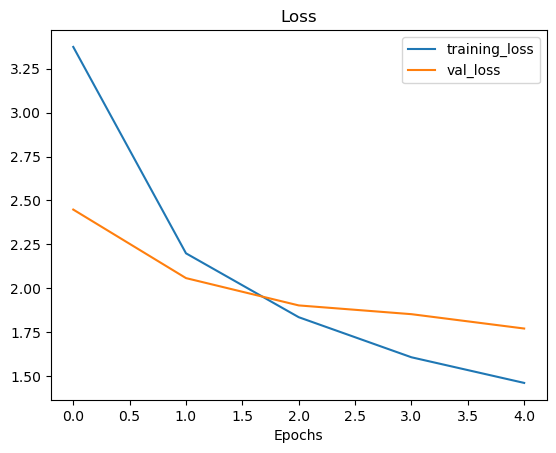

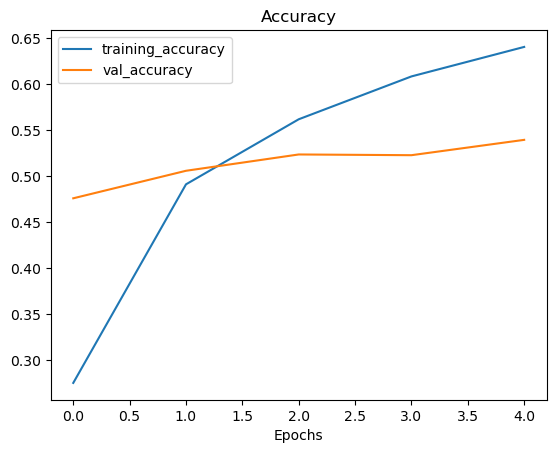

In [27]:
plot_loss_curves(history_10_percent)

> Accordinig to the history, the model is not learning in the correct manner so we need to fine-tune the model. The model is over-fitting

## Fine-tuning